## Import Dependencies

In [62]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[1]
sys.path.append(str(repo_root))

In [63]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from mplsoccer import Pitch, VerticalPitch
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.special import comb

from football_models.model_utils.hawkeye_data_loader import *

## Global Constants and Lookups

In [ ]:
DATA_DIR = '/path/to/processed_minutes'

COLS_TO_KEEP = [
    'time_key',    
    'heId', 
    'team_id', 
    'jersey_number', 
    'player_speed', 
    'player_role', 
    'player_x', 
    'player_y', 
    'ball_status', 
    'team_possession'
]

The raw feed identifies participants using internal UUIDs for teams and players. To make the analysis human-readable and facilitate scouting-style reporting, we map these identifiers to actual team names and player surnames.

In [22]:
TEAM_ID_MAP = {
    '421a0cc7-59f9-4871-8b6d-08d9a053a2de': 'Napoli', 
    '09bc60db-076b-4398-8b72-08d9a053a2de': 'Udinese' 
}

PLAYER_NAME_MAP = {
    ('Napoli', 1): 'Meret',
    ('Napoli', 5): 'Jesus',
    ('Napoli', 3): 'Min-Jae',
    ('Napoli', 17): 'Olivera',
    ('Napoli', 22): 'Di Lorenzo',
    ('Napoli', 99): 'Anguissa',
    ('Napoli', 68): 'Lobotka',
    ('Napoli', 20): 'Zielinski',
    ('Napoli', 7): 'Elmas',
    ('Napoli', 9): 'Osimhen',
    ('Napoli', 11): 'Lozano',
    ('Napoli', 55): 'Ostigard',
    ('Napoli', 6): 'Rui',
    ('Napoli', 91): 'Ndombele',
    ('Napoli', 21): 'Politano',
    
    ('Udinese', 1): 'Silvestri',
    ('Udinese', 29): 'Bijol',
    ('Udinese', 18): 'Perez',
    ('Udinese', 23): 'Ebosse',
    ('Udinese', 5): 'Arslan',
    ('Udinese', 11): 'Walace',
    ('Udinese', 4): 'Lovric',
    ('Udinese', 19): 'Ehizibue',
    ('Udinese', 37): 'Pereyra',
    ('Udinese', 10): 'Deulofeu',
    ('Udinese', 9): 'Beto',
    ('Udinese', 24): 'Samardzic', 
    ('Udinese', 30): 'Ilija Nestorovski', 
    ('Udinese', 8): 'Jajalo',
    ('Udinese', 7): 'Success' 
}

HOME_TEAM = 'Napoli' 
AWAY_TEAM = 'Udinese'

## Data Preprocessing

Sony Hawk-Eye tracking data is high-density (50 fps). To prevent memory overhead, the data is split into 1-minute segments following this naming convention:

```
..._{half}_{minute}_{extra_time}_full.csv
```

**Note**: The second half starts at minute `45`. Stoppage time is handled by the extra_time index (e.g., `1_45_1` for the first minute of first-half injury time).

Here is a brief overview of all helper functions stored in `hawkeye_data_loader.py`:

| Function | Purpose |
| --- | --- |
| `parse_file_sequence` | Uses Regex to extract half/minute/stoppage info from filenames for chronological sorting. |
| `process_tracking_files` | Loops through CSVs, standardizes continuous time, and groups data by player (Team + Jersey). |
| `create_player_dataframes` | Aggregates minute-chunks into full-match profiles and maps raw IDs to human-readable names. |
| `convert_and_separate` | Transforms coordinates to Wyscout scale (0-100) and standardizes attacking direction (Left → Right). |
| `get_outfield_starters` | Identifies and filters the starting 10 outfielders based on role and appearance in the first 10 seconds. |

In [23]:
all_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
sorted_files = sorted(all_files, key=parse_file_sequence)

In [24]:
player_data_store = process_tracking_files(sorted_files, DATA_DIR, COLS_TO_KEEP)

Starting processing on 99 files...
Processed file 0/99: kk_1_1_full.csv | Half: 1 | Max Time: 59.98
Processed file 10/99: k_1_11_full.csv | Half: 1 | Max Time: 659.89
Processed file 20/99: k_1_21_full.csv | Half: 1 | Max Time: 1259.79
Processed file 30/99: k_1_31_full.csv | Half: 1 | Max Time: 1859.67
Processed file 40/99: k_1_41_full.csv | Half: 1 | Max Time: 2459.57
Processed file 50/99: k_2_48_full.csv | Half: 2 | Max Time: 3059.23
Processed file 60/99: k_2_58_full.csv | Half: 2 | Max Time: 3659.12
Processed file 70/99: k_2_68_full.csv | Half: 2 | Max Time: 4259.02
Processed file 80/99: k_2_78_full.csv | Half: 2 | Max Time: 4858.94
Processed file 90/99: k_2_88_full.csv | Half: 2 | Max Time: 5458.84
Processing complete. Chunks stored in memory.


In [25]:
player_dfs = create_player_dataframes(player_data_store, TEAM_ID_MAP, PLAYER_NAME_MAP)

Aggregating and naming players...
Successfully created 30 unique player profiles.
----------------------------------------
SUCCESS: All players were successfully assigned a name!


In [26]:
home_team_dfs, away_team_dfs = convert_and_separate(
    player_dfs, 
    home_team_name=HOME_TEAM,
    pitch_length=105.0, 
    pitch_width=68.0
)

Standardizing and separating data for Home Team: Napoli...
Process complete.
- Skipped conversion for 0 players (already Wyscout).
- Home Team Players: 15
- Away Team Players: 15


In [27]:
starters_data = get_outfield_starters(home_team_dfs)

for player in starters_data:
    p_key = player['key']
    p_df = player['df']
    print(f"Ready to plot: {p_key} (Frames: {len(p_df)})")

Ready to plot: Napoli_Min-Jae (Frames: 294637)
Ready to plot: Napoli_Jesus (Frames: 187310)
Ready to plot: Napoli_Elmas (Frames: 291462)
Ready to plot: Napoli_Osimhen (Frames: 291934)
Ready to plot: Napoli_Lozano (Frames: 186119)
Ready to plot: Napoli_Olivera (Frames: 143999)
Ready to plot: Napoli_Zielinski (Frames: 205132)
Ready to plot: Napoli_Di Lorenzo (Frames: 291940)
Ready to plot: Napoli_Lobotka (Frames: 292764)
Ready to plot: Napoli_Anguissa (Frames: 291885)


## Player Movement Heatmap

A **player movement heatmap** is a powerful diagnostic tool that translates millions of data points into a visual story of a player's spatial footprint. 

For coaches, it serves as a tactical audit to verify positional discipline - such as ensuring a winger provides width or a holding midfielder secures "Zone 14"—while also highlighting fatigue through shifts in coverage between halves. 

For the audience, these visualizations provide context beyond the scoreboard, revealing the "invisible" work of players who disrupt play or drop deep to link the attack, ultimately making complex tactical roles easier to understand and compare.

In [28]:
player_key = list(home_team_dfs.keys())[4]
df_player = home_team_dfs[player_key]
df_player['team_id'] = df_player['team_id'].astype(str)
df_player['team_possession'] = df_player['team_possession'].astype(str)

df_in_possession = df_player[df_player['team_id'] == df_player['team_possession']]
df_out_possession = df_player[df_player['team_id'] != df_player['team_possession']]

df_1st_half = df_player[df_player['half'] == 1].copy()
df_2nd_half = df_player[df_player['half'] == 2].copy()

In [66]:
def plot_player_heatmap(player_df, title=None, sigma=2, ax=None):
    plt.style.use('default') 
    
    if player_df.empty:
        if ax is not None:
            ax.text(50, 50, "No Data Available", ha='center', color='red')
        return ax

    x = player_df['player_x'].values
    y = player_df['player_y'].values
    
    # Create 2D histogram
    heatmap, _, _ = np.histogram2d(x, y, bins=100, range=[[0, 100], [0, 100]])
    
    # Smooth the surface
    heatmap_smooth = gaussian_filter(heatmap, sigma=sigma)
    
    pitch = VerticalPitch(
        pitch_type='wyscout', 
        pitch_color='white', 
        line_color='black', 
        line_zorder=3
    )
    
    if ax is None:
        fig, ax = pitch.draw(figsize=(12, 8))
        fig.set_facecolor('white')
    else:
        pitch.draw(ax=ax)

    # 4. Custom Green Colormap
    colors = ["#ffffff", "#c9eac3", "#78c679", "#41ab5d", "#006837", "#00441b"]
    cmap = mcolors.LinearSegmentedColormap.from_list("ContourGreen", colors)
    
    y_grid = np.linspace(0, 100, heatmap_smooth.shape[1])
    x_grid = np.linspace(0, 100, heatmap_smooth.shape[0])
    Y, X = np.meshgrid(y_grid, x_grid)
    
    v_max = heatmap_smooth.max()
    if v_max > 0:
        levels = np.linspace(v_max * 0.05, v_max, 7)

        ax.contourf(Y, X, heatmap_smooth, cmap=cmap, levels=levels, zorder=2, alpha=1.0)

    if title:
        ax.set_title(title, fontsize=16, pad=1)

    return ax

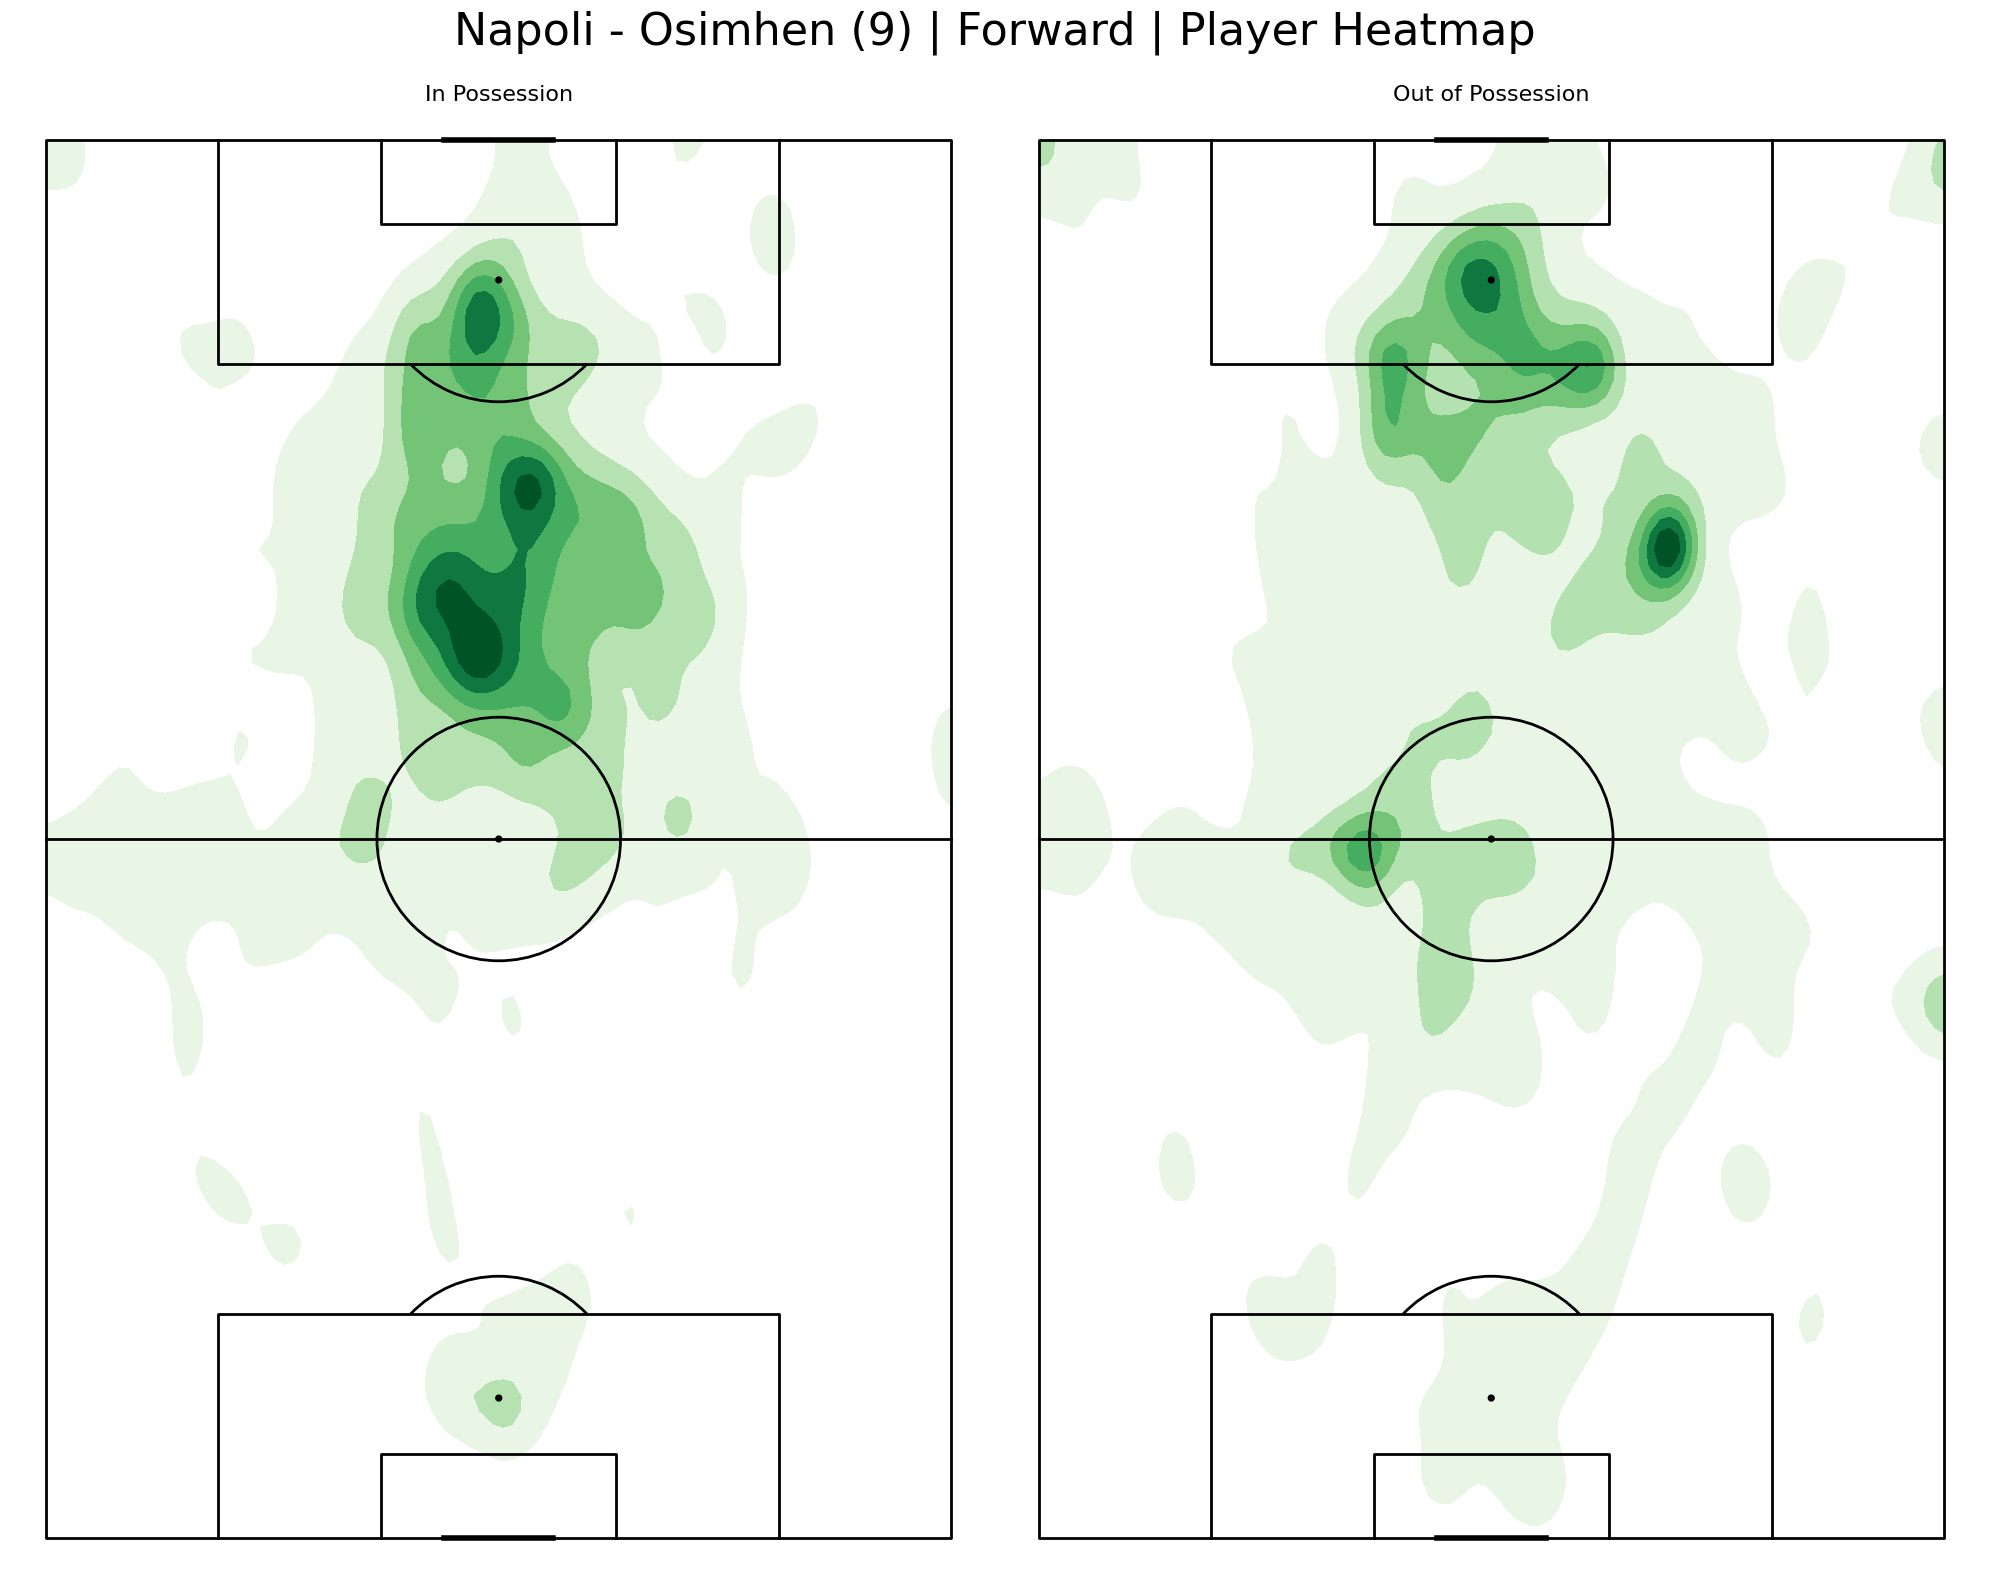

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16), facecolor='white')

plot_player_heatmap(df_in_possession, title="In Possession", ax=ax1)
plot_player_heatmap(df_out_possession, title="Out of Possession", ax=ax2)

p_name = df_player['player_name'].iloc[0]
j_num  = df_player['jersey_number'].iloc[0]
t_name = df_player['team_name'].iloc[0]
p_role = df_player['player_role'].iloc[0] if 'player_role' in df_player.columns else "Unknown"
plt.suptitle(f"{t_name} - {p_name} ({j_num}) | {p_role} | Player Heatmap", 
             fontsize=32, y=1.0)

plt.tight_layout()
plt.show()

Comparing the `In Possession` and `Out of Possession` heatmaps for `Osimhen` provides a clear look at how his tactical responsibilities shift based on which team has the ball.

When Napoli has the ball, Osimhen operates as a classic high-central target. When Udinese has the ball, Osimhen’s footprint changes to reflect his role in the team's pressing structure:
- **The High Press**: His activity shifts even higher up the pitch, often deep into the opponent’s penalty box. This suggests he is actively harassing the goalkeeper and center-backs to disrupt their build-up from the back.
- **Channel Running**: Unlike his "In Possession" state, he drifts significantly more toward the right flank when defending. This indicates he is likely tasked with "shuttling" to close down the opponent's left-back or covering space when a teammate triggers a press.
- **Midfield Support**: We can also see a small cluster of activity near the center circle, showing him dropping back slightly to congest the passing lanes and prevent easy balls into the Udinese midfield.

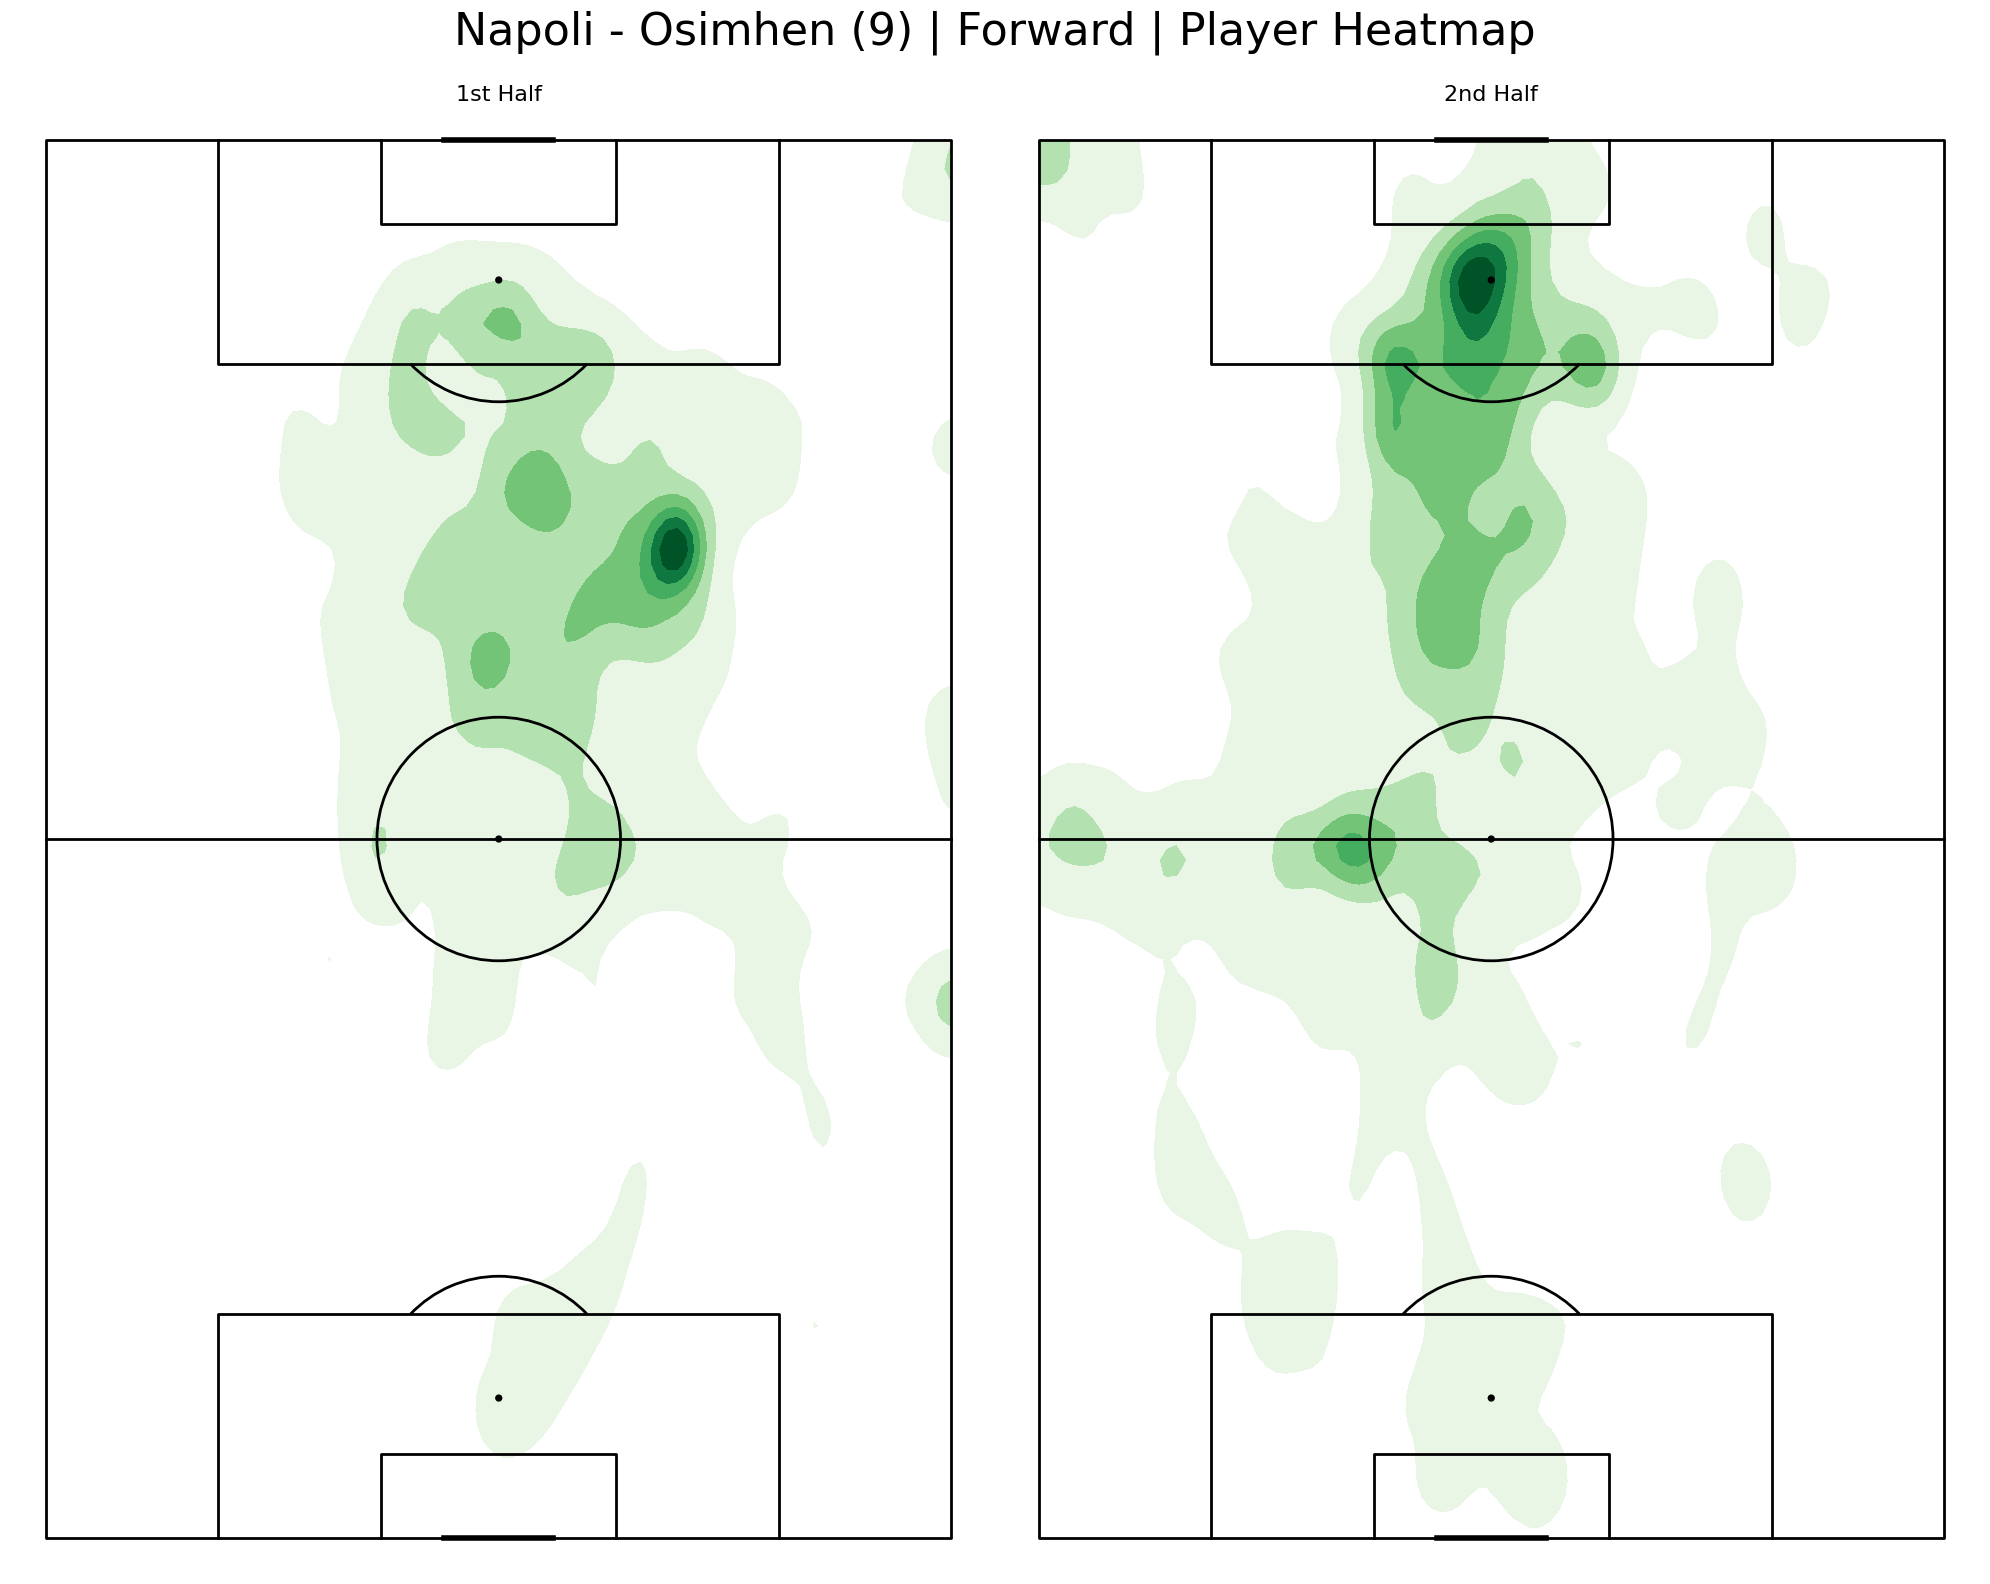

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16), facecolor='white')

plot_player_heatmap(df_1st_half, title="1st Half", ax=ax1)
plot_player_heatmap(df_2nd_half, title="2nd Half", ax=ax2)

p_name = df_player['player_name'].iloc[0]
j_num  = df_player['jersey_number'].iloc[0]
t_name = df_player['team_name'].iloc[0]
p_role = df_player['player_role'].iloc[0] if 'player_role' in df_player.columns else "Unknown"
plt.suptitle(f"{t_name} - {p_name} ({j_num}) | {p_role} | Player Heatmap", 
             fontsize=32, y=1.0)

plt.tight_layout()
plt.show()

`Osimhen`’s heatmap reveals a **significant tactical shift** between the `1st half` and the `2nd half`:

In the first half, Osimhen’s activity is concentrated in the right-half space and the front edge of the middle third. Rather than acting as a static target man, he was **dropping deeper** and **drifting wide** to link up with the midfield and wingers. This suggests he was focused on stretching the defense and creating passing lanes for teammates rather than occupying the box himself.

The second half shows a much more **aggressive, vertical positioning**. His primary "hotspot" shifts directly into the opponent's penalty area and the central zone just outside it. This indicates a transition to a more traditional "number 9" role.

## Distance Covered and High-Intensity Runs

In soccer analytics, **Speed Zones (SZ)** are used to categorize a player's physical output based on their velocity, typically measured in meters per second (m/s).

| Zone | Category | Typical Speed Range (m/s) | Typical Speed Range (km/h) |
| --- | --- | --- | --- |
| `SZ1` | Walking | 0 – 2.0 | 0 – 7.2 |
| `SZ2` | Jogging | 2.0 – 4.0 | 7.2 – 14.4 |
| `SZ3` | Running | 4.0 – 5.5 | 14.4 – 19.8 |
| `SZ4` | High-Intensity Running (HIR) | 5.5 – 7.0  | 19.8 – 25.2 |
| `SZ5` | Sprinting | > 7.0 | > 25.2 |

In [32]:
ZONES = {
    'SZ1 (Walk)': (0.0, 2.0),
    'SZ2 (Jog)': (2.0, 4.0),
    'SZ3 (Run)': (4.0, 5.5),
    'SZ4 (High-Int)': (5.5, 7.0),
    'SZ5 (Sprint)': (7.0, 15.0)
} 

In [33]:
def calculate_comprehensive_speed_zones(starters_data):
    results_raw = []
    results_norm = []
    
    for player in starters_data:
        df = player['df'].copy().sort_values('time_key')
        
        duration_sec = df['time_key'].max() - df['time_key'].min()
        minutes_played = duration_sec / 60.0
        
        if minutes_played < 1.0: 
            continue 

        df['dt'] = df['time_key'].diff().fillna(0)
        df['frame_dist'] = df['player_speed'] * df['dt']
        
        base_stats = {
            'key': player['key'],
            'name': df['player_name'].iloc[0],
            'jersey': player['jersey'],
            'role': df['player_role'].iloc[0],
            'minutes_played': minutes_played
        }
        
        raw_breakdown = {}
        norm_breakdown = {}
        
        for sz_name, (low, high) in ZONES.items():
            mask = (df['player_speed'] >= low) & (df['player_speed'] < high)
            raw_dist = df.loc[mask, 'frame_dist'].sum()
            
            raw_breakdown[sz_name] = raw_dist
            norm_breakdown[sz_name] = raw_dist / minutes_played
            
        stats_raw = base_stats.copy()
        stats_raw['total_dist'] = df['frame_dist'].sum()
        stats_raw['sz_breakdown'] = raw_breakdown
        stats_raw['hi_dist'] = raw_breakdown['SZ4 (High-Int)'] + raw_breakdown['SZ5 (Sprint)']
        results_raw.append(stats_raw)
        
        stats_norm = base_stats.copy()
        stats_norm['dist_per_min'] = df['frame_dist'].sum() / minutes_played
        stats_norm['sz_breakdown_norm'] = norm_breakdown
        stats_norm['hi_dist_norm'] = norm_breakdown['SZ4 (High-Int)'] + norm_breakdown['SZ5 (Sprint)']
        results_norm.append(stats_norm)
        
    return results_raw, results_norm

In [34]:
sz_analysis, sz_analysis_norm = calculate_comprehensive_speed_zones(starters_data)

In [35]:
def plot_speed_zone_breakdown_clean(sz_analysis):
    fig, axes = plt.subplots(5, 2, figsize=(20, 25), facecolor='white')
    axes = axes.flatten()
    
    zone_colors = ['#e0e0e0', '#bdbdbd', '#757575', '#f44336', '#b71c1c']
    
    for i, stats in enumerate(sz_analysis):
        ax = axes[i]
        
        labels = ['SZ1', 'SZ2', 'SZ3', 'SZ4', 'SZ5']
        values = list(stats['sz_breakdown'].values())
        
        bars = ax.bar(labels, values, color=zone_colors, edgecolor='black', alpha=0.8)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 10,
                    f'{int(height)}m', ha='center', va='bottom', fontsize=10)
        
        ax.set_title(f"#{stats['jersey']} {stats['name']} | {stats['role']}", fontsize=16)
        ax.set_ylabel("Distance (m)")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.suptitle("Squad Speed Zone Profile: Raw Tracking Analysis", 
                 fontsize=32, y=1.01)
    plt.tight_layout()
    plt.show()

Here we can visualize the SZ distribution for each starting outfielder of the team.

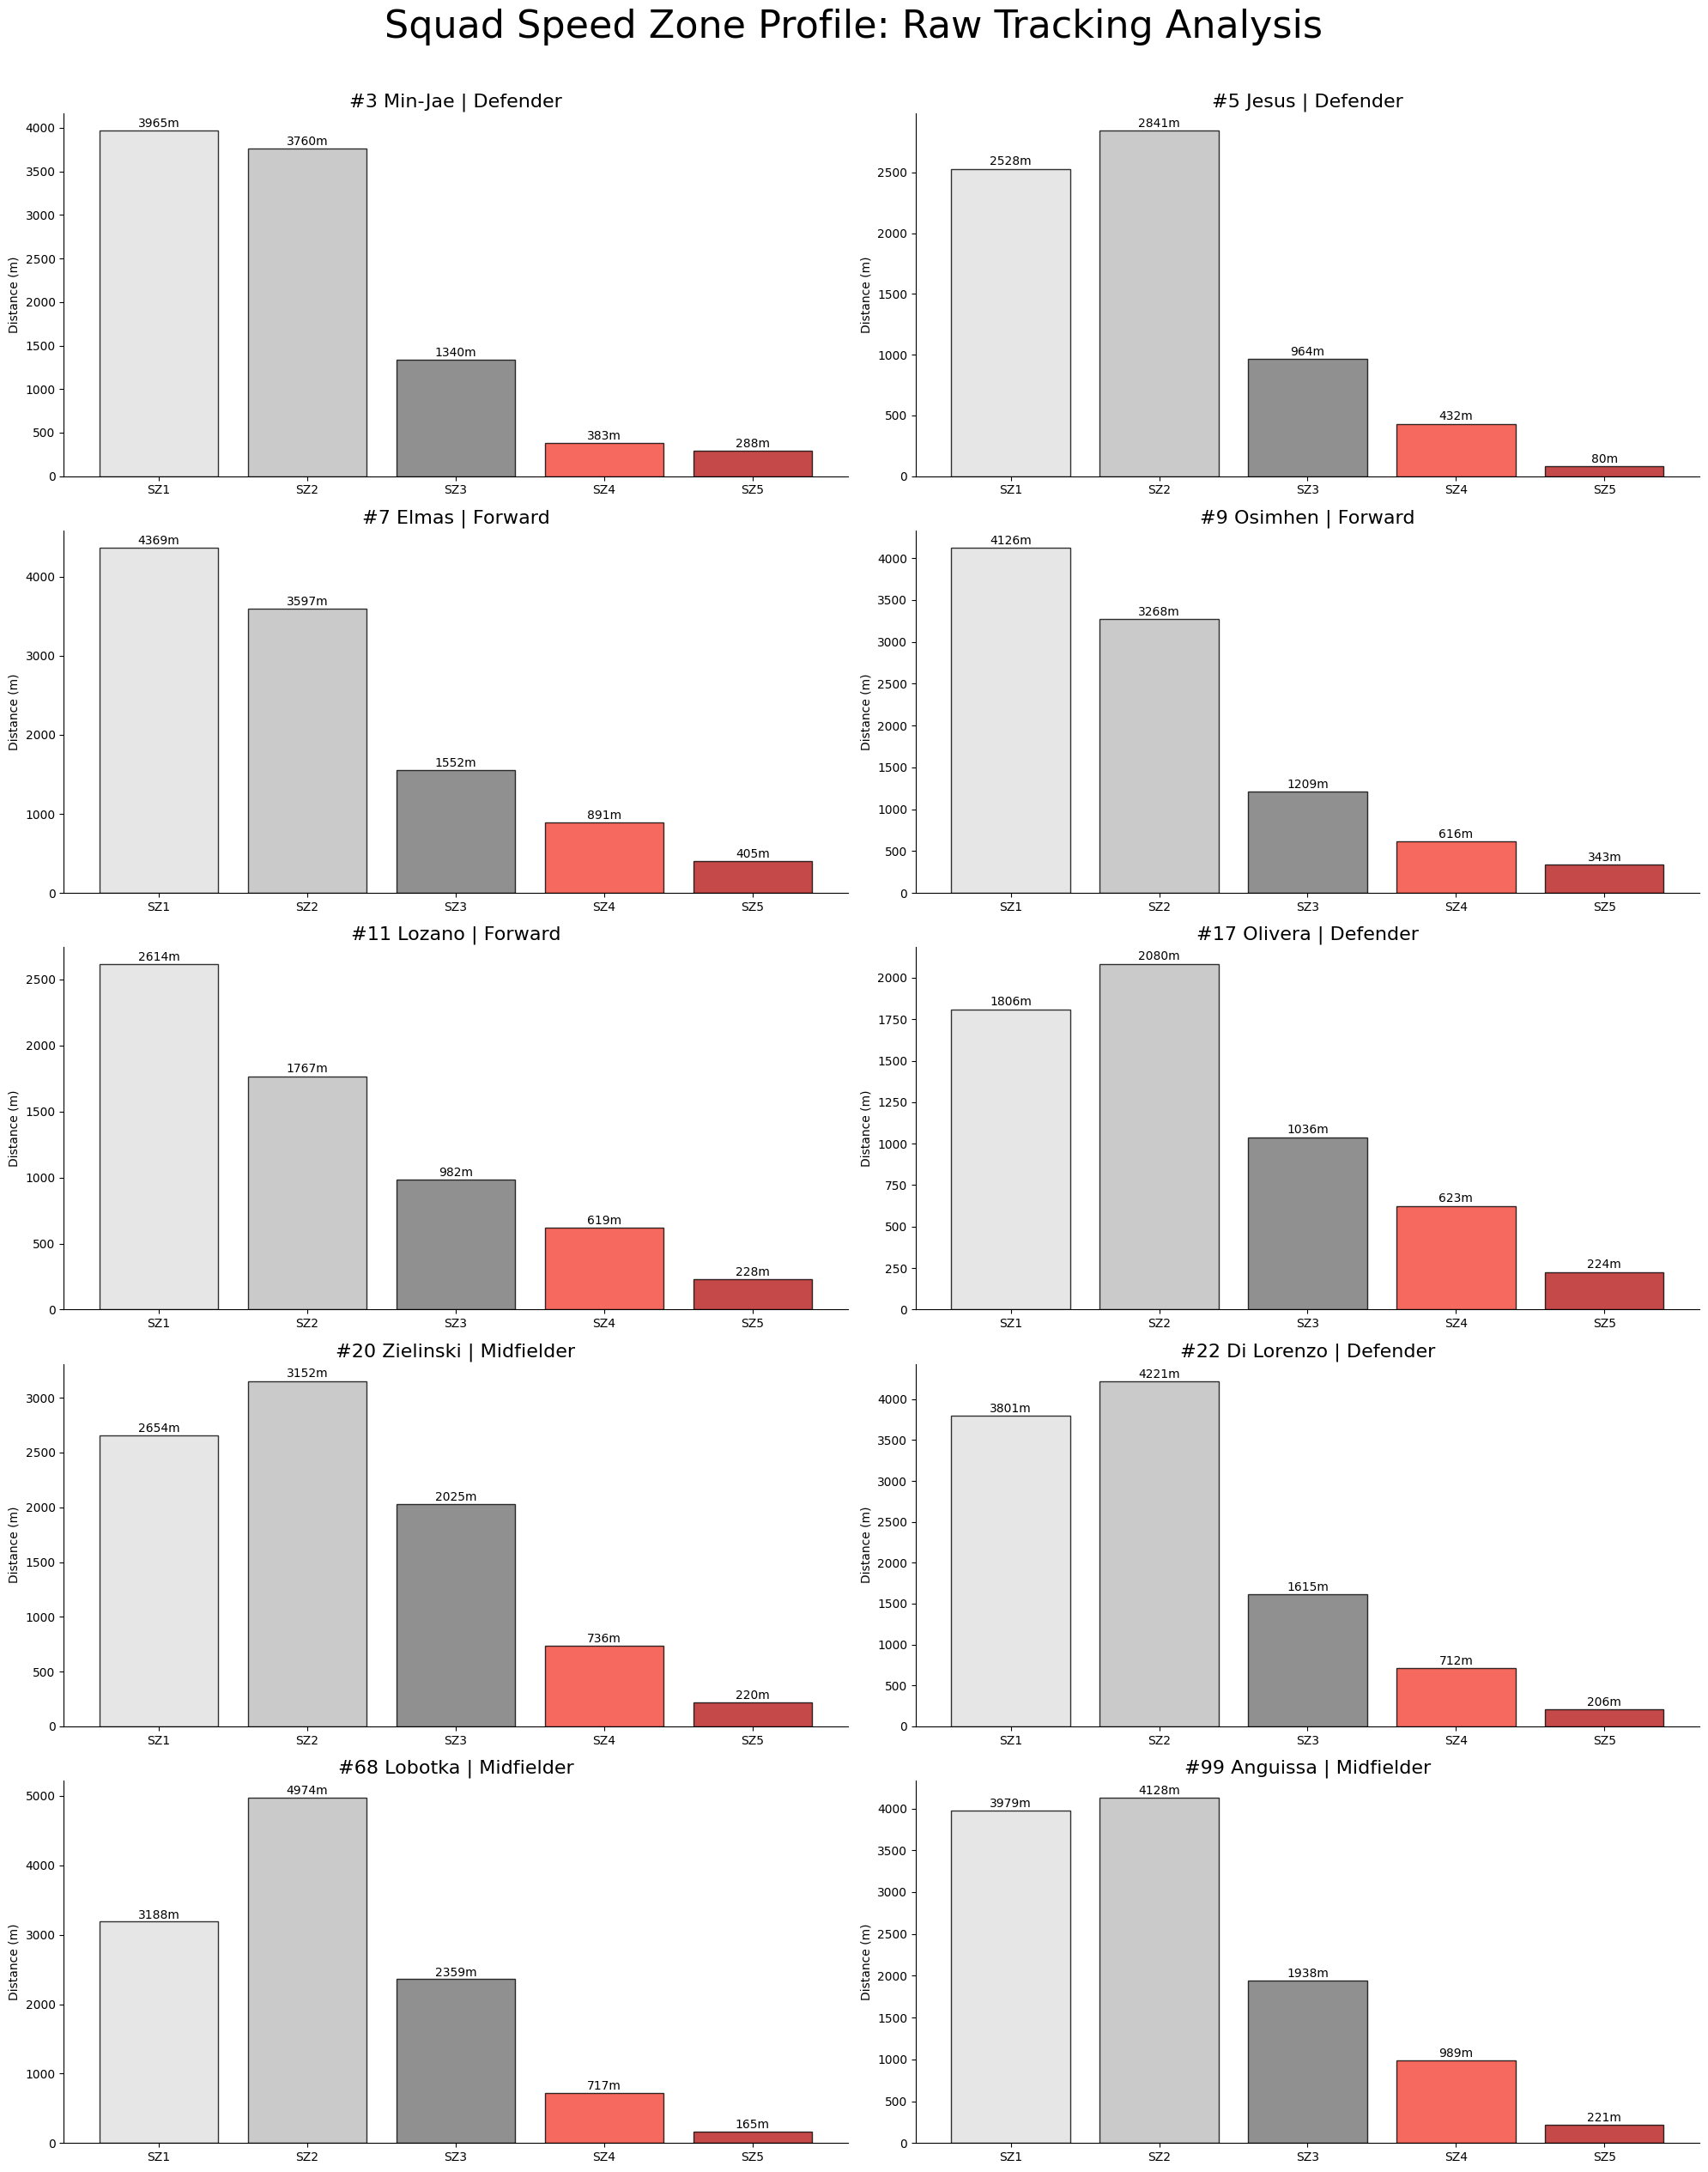

In [36]:
plot_speed_zone_breakdown_clean(sz_analysis)

In [37]:
def plot_normalized_intensity_scatter(sz_analysis):
    names = [s['name'] for s in sz_analysis]
    dist_pm = [s['dist_per_min'] for s in sz_analysis]
    hi_pm = [s['hi_dist_norm'] for s in sz_analysis]
    roles = [s['role'] for s in sz_analysis]
    jerseys = [s['jersey'] for s in sz_analysis]

    plt.figure(figsize=(20, 14), facecolor='white')
    ax = plt.gca()

    # Means for quadrants
    plt.axvline(np.mean(dist_pm), color='grey', linestyle='--', alpha=0.4)
    plt.axhline(np.mean(hi_pm), color='grey', linestyle='--', alpha=0.4)

    role_colors = {'Defender': '#3498db', 'Midfielder': '#2ecc71', 'Forward': '#e74c3c'}
    colors = [role_colors.get(r, '#95a5a6') for r in roles]

    plt.scatter(dist_pm, hi_pm, s=400, c=colors, edgecolors='black', alpha=0.8, zorder=3)

    for i, name in enumerate(names):
        plt.annotate(f"#{jerseys[i]} {name.split()[-1]}", 
                     (dist_pm[i], hi_pm[i]),
                     xytext=(0, 15), textcoords="offset points", ha='center')

    plt.title("Physical Efficiency: Total Volume vs. Intensity (Per Minute)", fontsize=22, pad=20)
    plt.xlabel("Total Distance per Minute (m/min)", fontsize=14)
    plt.ylabel("High Intensity Distance per Minute (m/min)", fontsize=14)
    
    # Custom Legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=k,
                              markerfacecolor=v, markersize=12, markeredgecolor='black') 
                       for k, v in role_colors.items()]
    ax.legend(handles=legend_elements, title="Position", loc='upper left')

    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

By using the mean lines (the dashed grey lines), we can categorize the players into four distinct physical profiles:

**Top Right: High Volume, High Intensity**

These players are the physical heartbeat of the team. They cover a lot of ground and do it at high speeds.
- 17 Olivera
- 20 Zielinski

**Top Left: Low Volume, High Intensity**

These players are "economical." they don't run much overall, but when they move, it's almost always a high-speed burst.
- 11 Lozano
- 7 Elmas

**Bottom Right: High Volume, Low Intensity**

These players are always moving to provide passing lanes or cover space, but they rarely need to hit top gear.
- 68 Lobotka
- 99 Anguissa

**Bottom Left: Low Volume, Low Intensity**

In this match, these players were the most physically "quiet," either by design or tactical necessity.
- 9 Osimhen
- 3 Min-Jae
- 5 Jesus

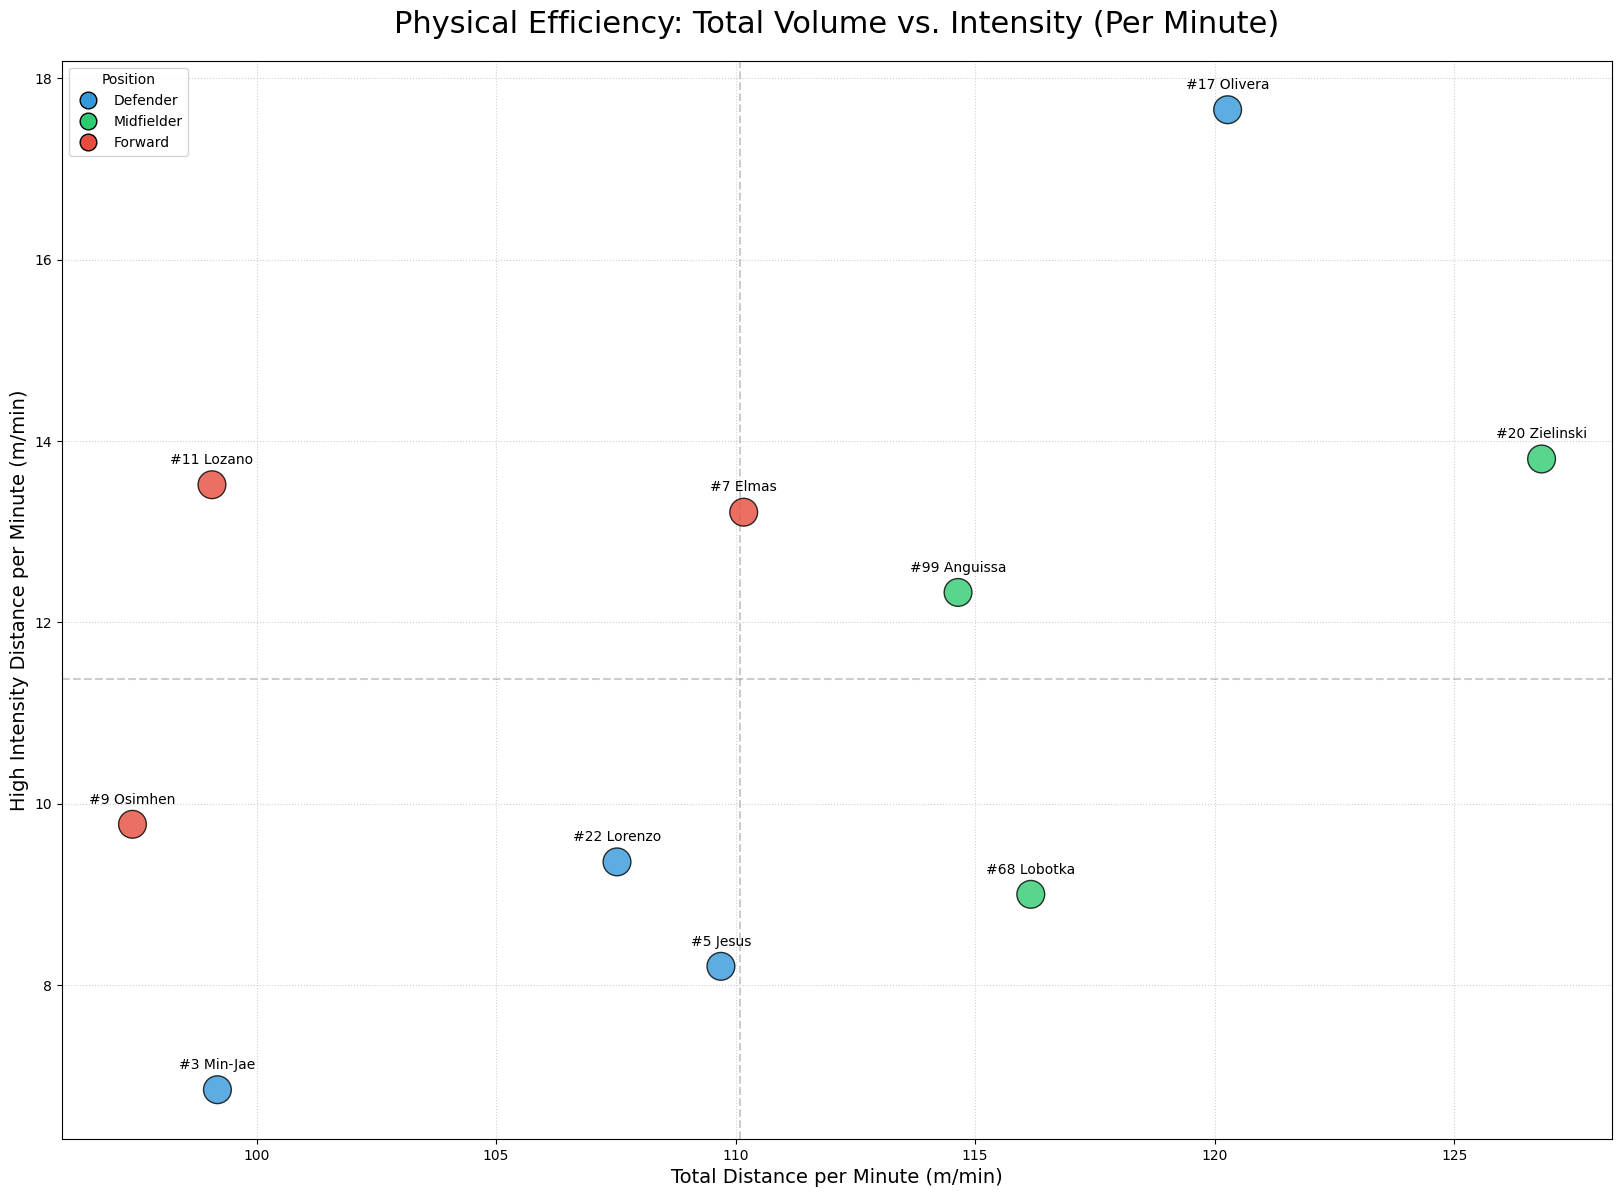

In [38]:
plot_normalized_intensity_scatter(sz_analysis_norm)

We can also move beyond standard scatter plots by anchoring physical performance metrics, **Volume** and **Intensity**, directly onto the tactical positions where the work was performed.

We therefore created a hybrid visualization that anchors physical performance metrics directly onto the tactical positions where the work was performed.

**Core Design Logic**
- **Tactical Anchoring:** Uses mean $(x, y)$ coordinates to visualize the "tactical cost" of specific roles (e.g., wing-backs showing high-intensity nodes in advanced wide areas).
- **Dual-Metric Encoding:**
    * **Node Size:** Represents **Volume** (Total Distance per Minute).
    * **Node Color:** Represents **Intensity** (High-Intensity Distance per Minute).

#### Mathematical Scaling (The "Magnify" Mechanism)**
To ensure elite physical outputs are visually distinct from average work rates, the design utilizes **Min-Max Normalization** combined with a **Non-Linear Power Law**.

**Step 1: Feature Scaling** We first map the player's volume to a relative $0.0$ to $1.0$ scale based on the squad's performance range for that specific match:

$$norm\_vol = \frac{stats - min(vol)}{max(vol) - min(vol)}$$

**Step 2: Exponential Amplification** We then apply a power-law transformation to determine the final visual area ($S$):

$$S = Base + (norm\_vol^{p}) \cdot Scale$$

* **The Base ($2000$):** Establishes a "minimum floor" for node visibility.
* **The Power ($p = 1.5$):** This creates an **accelerated growth curve**. By using a power $> 1$, players in the top $10\%$ of the volume range appear significantly larger than those at the median.

In [39]:
def plot_physical_positional_map(sz_analysis_norm, starters_data):
    pitch = Pitch(pitch_type='wyscout', line_zorder=2)
    
    fig, ax = pitch.draw(figsize=(20, 16))
    fig.set_facecolor('white')

    all_volumes = [stats['dist_per_min'] for stats in sz_analysis_norm]
    min_vol, max_vol = min(all_volumes), max(all_volumes)

    plot_data = []
    for stats in sz_analysis_norm:
        player_df = next(p['df'] for p in starters_data if p['key'] == stats['key'])
        
        avg_x = player_df['player_x'].mean()
        avg_y = player_df['player_y'].mean()
        
        norm_size = (stats['dist_per_min'] - min_vol) / (max_vol - min_vol)

        magnified_size = 2000 + (norm_size ** 1.5) * 4000 
        
        plot_data.append({
            'name': stats['name'].split()[-1],
            'jersey': stats['jersey'],
            'avg_x': avg_x,
            'avg_y': avg_y,
            'size': magnified_size, 
            'intensity': stats['hi_dist_norm']
        })

    x = [p['avg_x'] for p in plot_data]
    y = [p['avg_y'] for p in plot_data]
    sizes = [p['size'] for p in plot_data]
    colors = [p['intensity'] for p in plot_data]

    sc = ax.scatter(x, y, s=sizes, c=colors, cmap='YlGnBu_r', 
                    edgecolor='black', linewidth=1.5, alpha=0.9, zorder=3)

    intensity_mean = np.mean(colors)

    for p in plot_data:
        text_color = 'black' if p['intensity'] > intensity_mean else 'white'
        
        ax.text(p['avg_x'], p['avg_y'], str(p['jersey']), 
                color=text_color, va='center', ha='center', 
                fontweight='bold', fontsize=12, zorder=4)
        
        radius_pts = (p['size'] / np.pi) ** 0.5
        
        ax.annotate(p['name'], 
                    xy=(p['avg_x'], p['avg_y']), 
                    xytext=(0, -(radius_pts + 5)),
                    textcoords='offset points',
                    va='top', 
                    ha='center', 
                    fontsize=11, 
                    fontweight='bold', 
                    color='black', 
                    zorder=4)

    cbar = plt.colorbar(sc, ax=ax, shrink=0.64, aspect=20, pad=0.02)
    cbar.set_label('High Intensity Distance per Min (m/min)', fontsize=14, labelpad=10)
    cbar.outline.set_linewidth(1)
    
    plt.title("Physical Workload Map: Positional Volume & Intensity", 
              fontsize=28)
    plt.show()

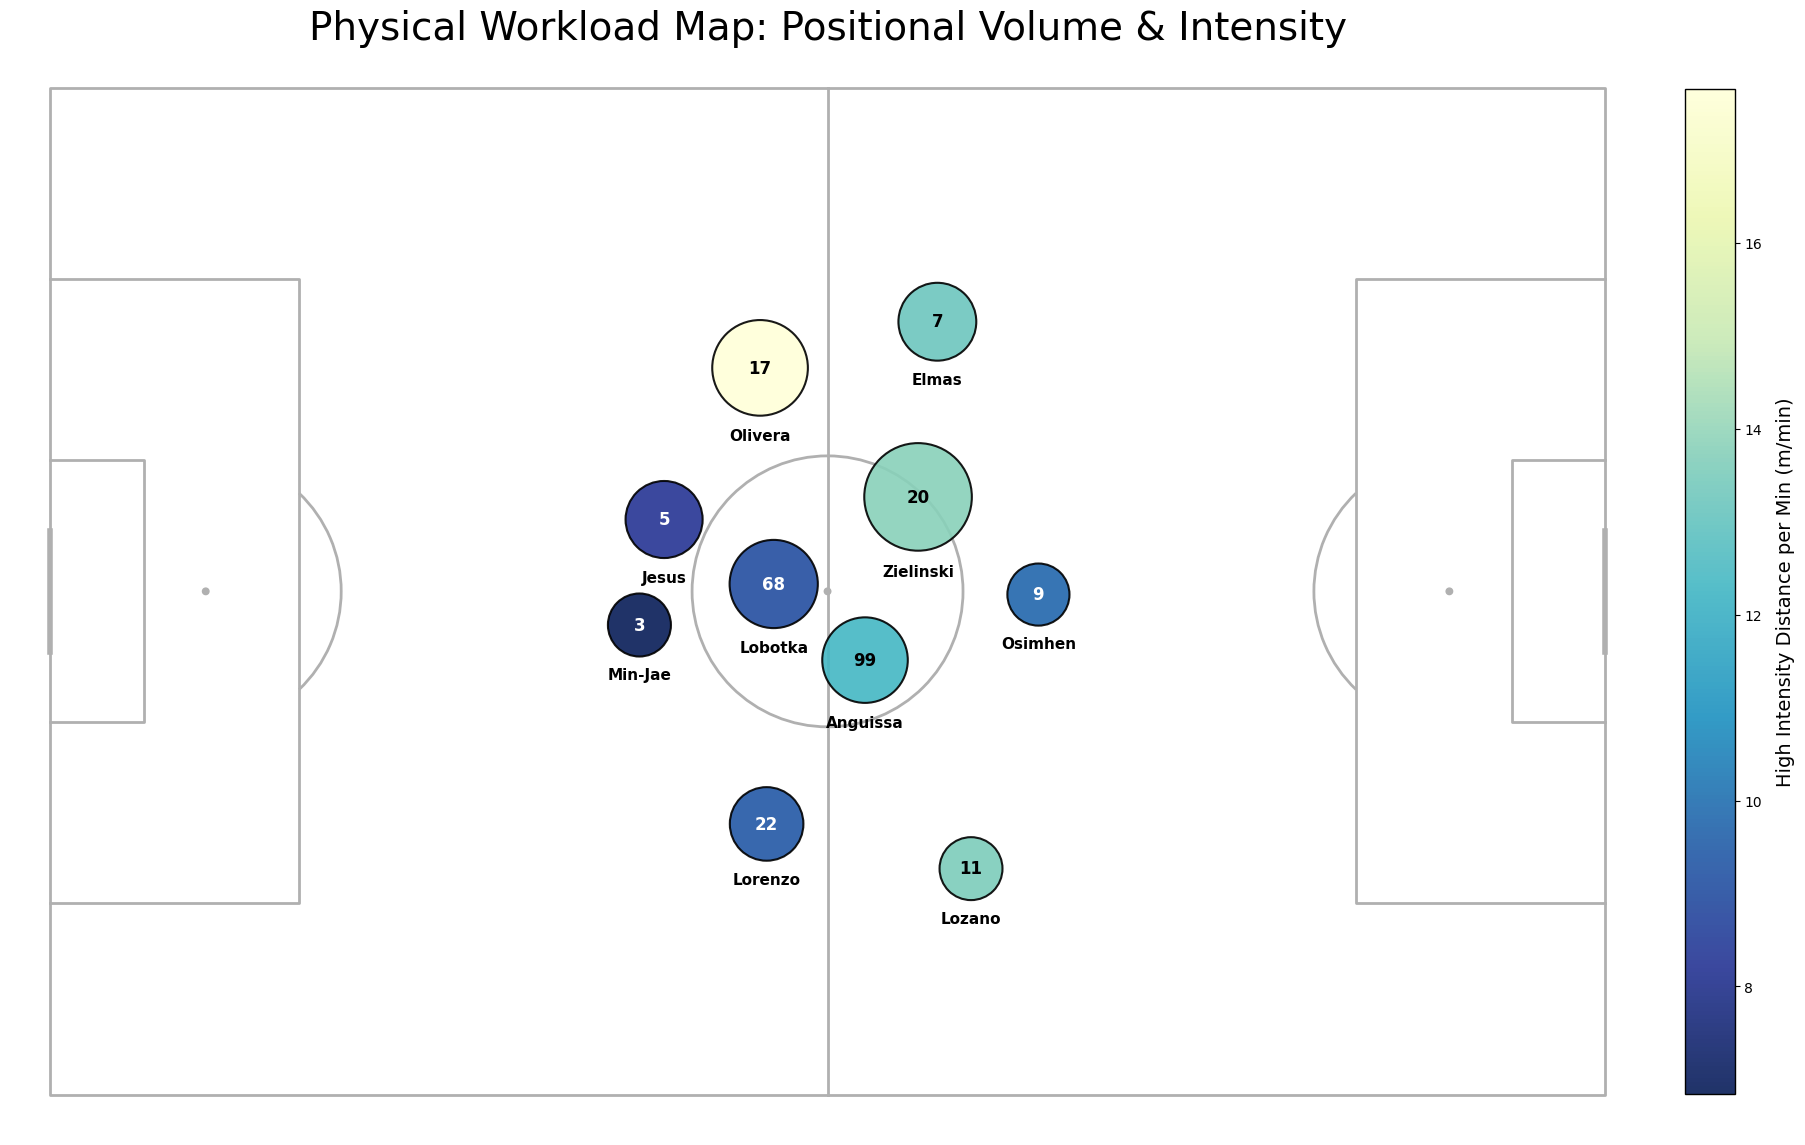

In [40]:
plot_physical_positional_map(sz_analysis_norm, starters_data)

## Speed by Position and Match Phase

Similar to the Speed Zone profile we built earlier, the **Speed by Position and Match Phase** provides a detailed look at the intensity patterns of each starting outfielder across the two primary phases of the game: `In Possession` and `Out of Possession`.

By observing the shape of the Kernel Density Estimation (KDE) curves - such as a broad, flat curve during the Out of Possession phase indicating aggressive pressing, or a "stretched" tail in the high-velocity range indicating explosive transitions - analysts can verify if a player is fulfilling their specific role.

In [41]:
def plot_player_speed_dist_ax(df_in, df_out, title, ax):
    def clean_existing_speed(df):
        if df is None or df.empty or 'player_speed' not in df.columns:
            return pd.Series(dtype=float)
        s = df['player_speed']
        return s[(s >= 0) & (s <= 16)].dropna()

    speed_in = clean_existing_speed(df_in)
    speed_out = clean_existing_speed(df_out)

    for threshold in [2.5, 5.0]:
        ax.axvline(threshold, color='grey', linestyle='--', linewidth=3, alpha=0.8, zorder=1)

    # Plot In Possession
    if not speed_in.empty:
        sns.kdeplot(speed_in, ax=ax, color='#4b4696', fill=True, alpha=0.3, 
                    linewidth=1.5, label='In Possession', zorder=2)
    
    # Plot Out of Possession
    if not speed_out.empty:
        sns.kdeplot(speed_out, ax=ax, color='#d05a7e', fill=True, alpha=0.3, 
                    linewidth=1.5, label='Out of Possession', zorder=2)

    # Formatting
    ax.set_xlim(0, 10)
    ax.set_ylim(0, None)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('m/s', fontsize=12)
    ax.set_ylabel('', fontsize=12)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

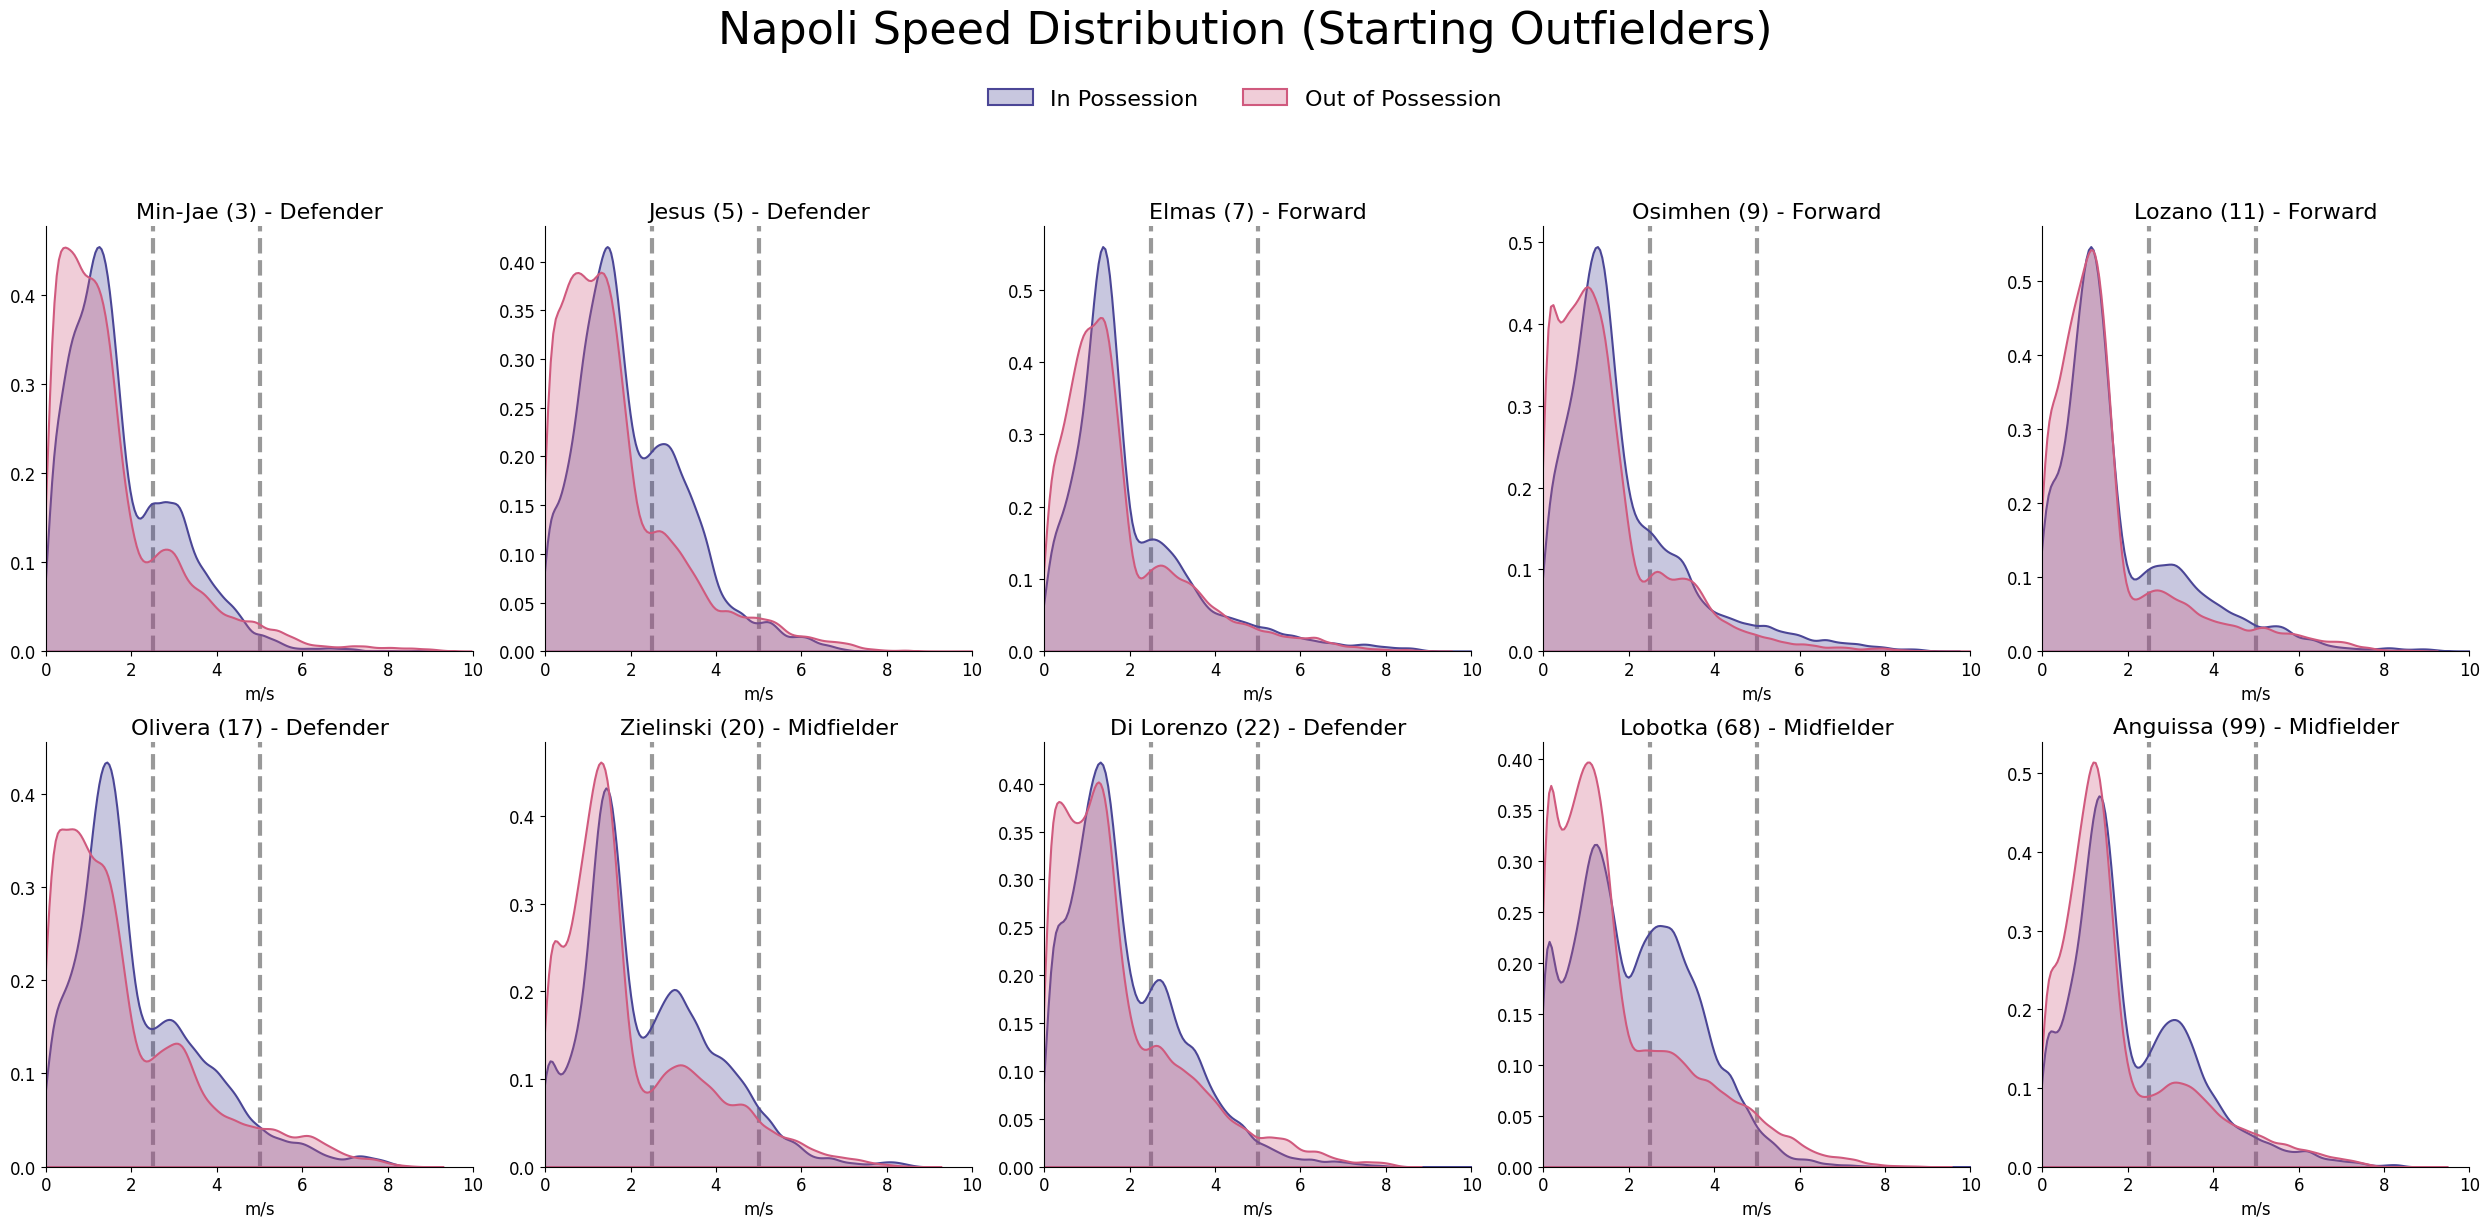

In [42]:
fig, axes = plt.subplots(2, 5, figsize=(25, 12), facecolor='white')
axes = axes.flatten()

team_name = starters_data[0]['df']['team_name'].iloc[0]
fig.suptitle(f"{team_name} Speed Distribution (Starting Outfielders)", 
             fontsize=32, y=1.05)

for i in range(10):
    ax = axes[i]
    
    if i < len(starters_data):
        player_info = starters_data[i]
        p_df = player_info['df']
        p_key = player_info['key'] 
        
        p_df['team_id'] = p_df['team_id'].astype(str)
        p_df['team_possession'] = p_df['team_possession'].astype(str)
        
        df_in = p_df[p_df['team_id'] == p_df['team_possession']]
        df_out = p_df[p_df['team_id'] != p_df['team_possession']]
        
        p_name = p_df['player_name'].iloc[0]
        j_num = player_info['jersey']
        p_role = p_df['player_role'].iloc[0]
        subplot_title = f"{p_name} ({j_num}) - {p_role}"

        plot_player_speed_dist_ax(df_in, df_out, subplot_title, ax)
    else:
        ax.axis('off')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), 
           ncol=2, frameon=False, fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Using `Lobotka` as an example, his speed distribution reveals a highly disciplined defensive anchor profile. Out of possession (pink), his activity is strictly concentrated at lower velocities, peaking sharply around 1 m/s, which indicates a focus on maintaining structural positioning rather than chasing the ball. Conversely, when in possession (blue), his profile shifts toward the "Jogging" zone (2.5–4 m/s), showing a more aggressive and mobile approach to support the build-up and constantly offer passing outlets.

## Team Workload

This section we generate a **Player Workload Timeline**, which compares an individual player's physical output against the collective team average on a minute-by-minute basis.

A coach can see exactly when a player’s output dips below the team average. If the team average is rising (high-intensity phase) but a player's red line is falling, it signals tactical switching off or physical fatigue.

In [43]:
def calculate_workload_metrics(home_team_dfs):
    all_player_workloads = {}
    
    # Calculate for each player
    for p_id, df in home_team_dfs.items():
        temp_df = df.copy().sort_values('time_key')
        
        dx = temp_df['player_x'].diff() * 1.05
        dy = temp_df['player_y'].diff() * 0.68
        dist = np.sqrt(dx**2 + dy**2)
        
        temp_df['match_minute'] = (temp_df['time_key'] // 60).astype(int)
        temp_df['dist_m'] = dist.fillna(0)
        
        minute_dist = temp_df.groupby('match_minute')['dist_m'].sum().reset_index()
        all_player_workloads[p_id] = minute_dist

    # Calculate Team Average per Minute
    outfield_ids = [p_id for p_id, df in home_team_dfs.items() 
                    if df['player_role'].iloc[0] != 'Goalkeeper']
    
    combined_dist = pd.concat([all_player_workloads[p_id] for p_id in outfield_ids])
    team_avg_workload = combined_dist.groupby('match_minute')['dist_m'].mean().reset_index()
    
    return all_player_workloads, team_avg_workload

In [44]:
def plot_starting_xi_intensity_v2(starters_data, player_workloads, team_avg_dist):
    fig, axes = plt.subplots(5, 2, figsize=(25, 25), facecolor='white')
    axes = axes.flatten()

    team_name = starters_data[0]['df']['team_name'].iloc[0]

    for i in range(10):
        ax = axes[i]
        
        if i < len(starters_data):
            player_info = starters_data[i]
            p_key = player_info['key']
            p_df = player_info['df']
            
            p_name = p_df['player_name'].iloc[0]
            p_jersey = player_info['jersey']
            p_role = p_df['player_role'].iloc[0]

            if p_key in player_workloads:
                w_df = player_workloads[p_key]

                ax.bar(team_avg_dist['match_minute'], team_avg_dist['dist_m'], 
                       color='#d3d3d3', alpha=1.0, label='Team Avg', width=0.9)
                
                ax.plot(w_df['match_minute'], w_df['dist_m'], 
                        color='#e31b23', linewidth=1.5, marker='o', markersize=3, 
                        label='Player Output', zorder=3)
                
                ax.set_title(f"#{p_jersey} {p_name} ({p_role})", fontsize=16)
                ax.set_facecolor('white')
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                
                ax.axvline(x=45, color='black', linestyle=':', alpha=0.3)
                
                ax.set_ylim(0, max(team_avg_dist['dist_m'].max(), w_df['dist_m'].max()) * 1.1)
                ax.grid(axis='y', linestyle=':', alpha=0.5)

                if i >= 8: ax.set_xlabel("Minute")
                if i % 2 == 0: ax.set_ylabel("Meters/Min")
            else:
                ax.text(0.5, 0.5, f"No Workload Data\n{p_name}", ha='center', va='center')
        else:
            ax.axis('off')

    plt.suptitle(f"{team_name} Squad Intensity Profile: Player vs. Team Avg", 
                 fontsize=32, y=1.0)
    
    plt.tight_layout()
    plt.show()

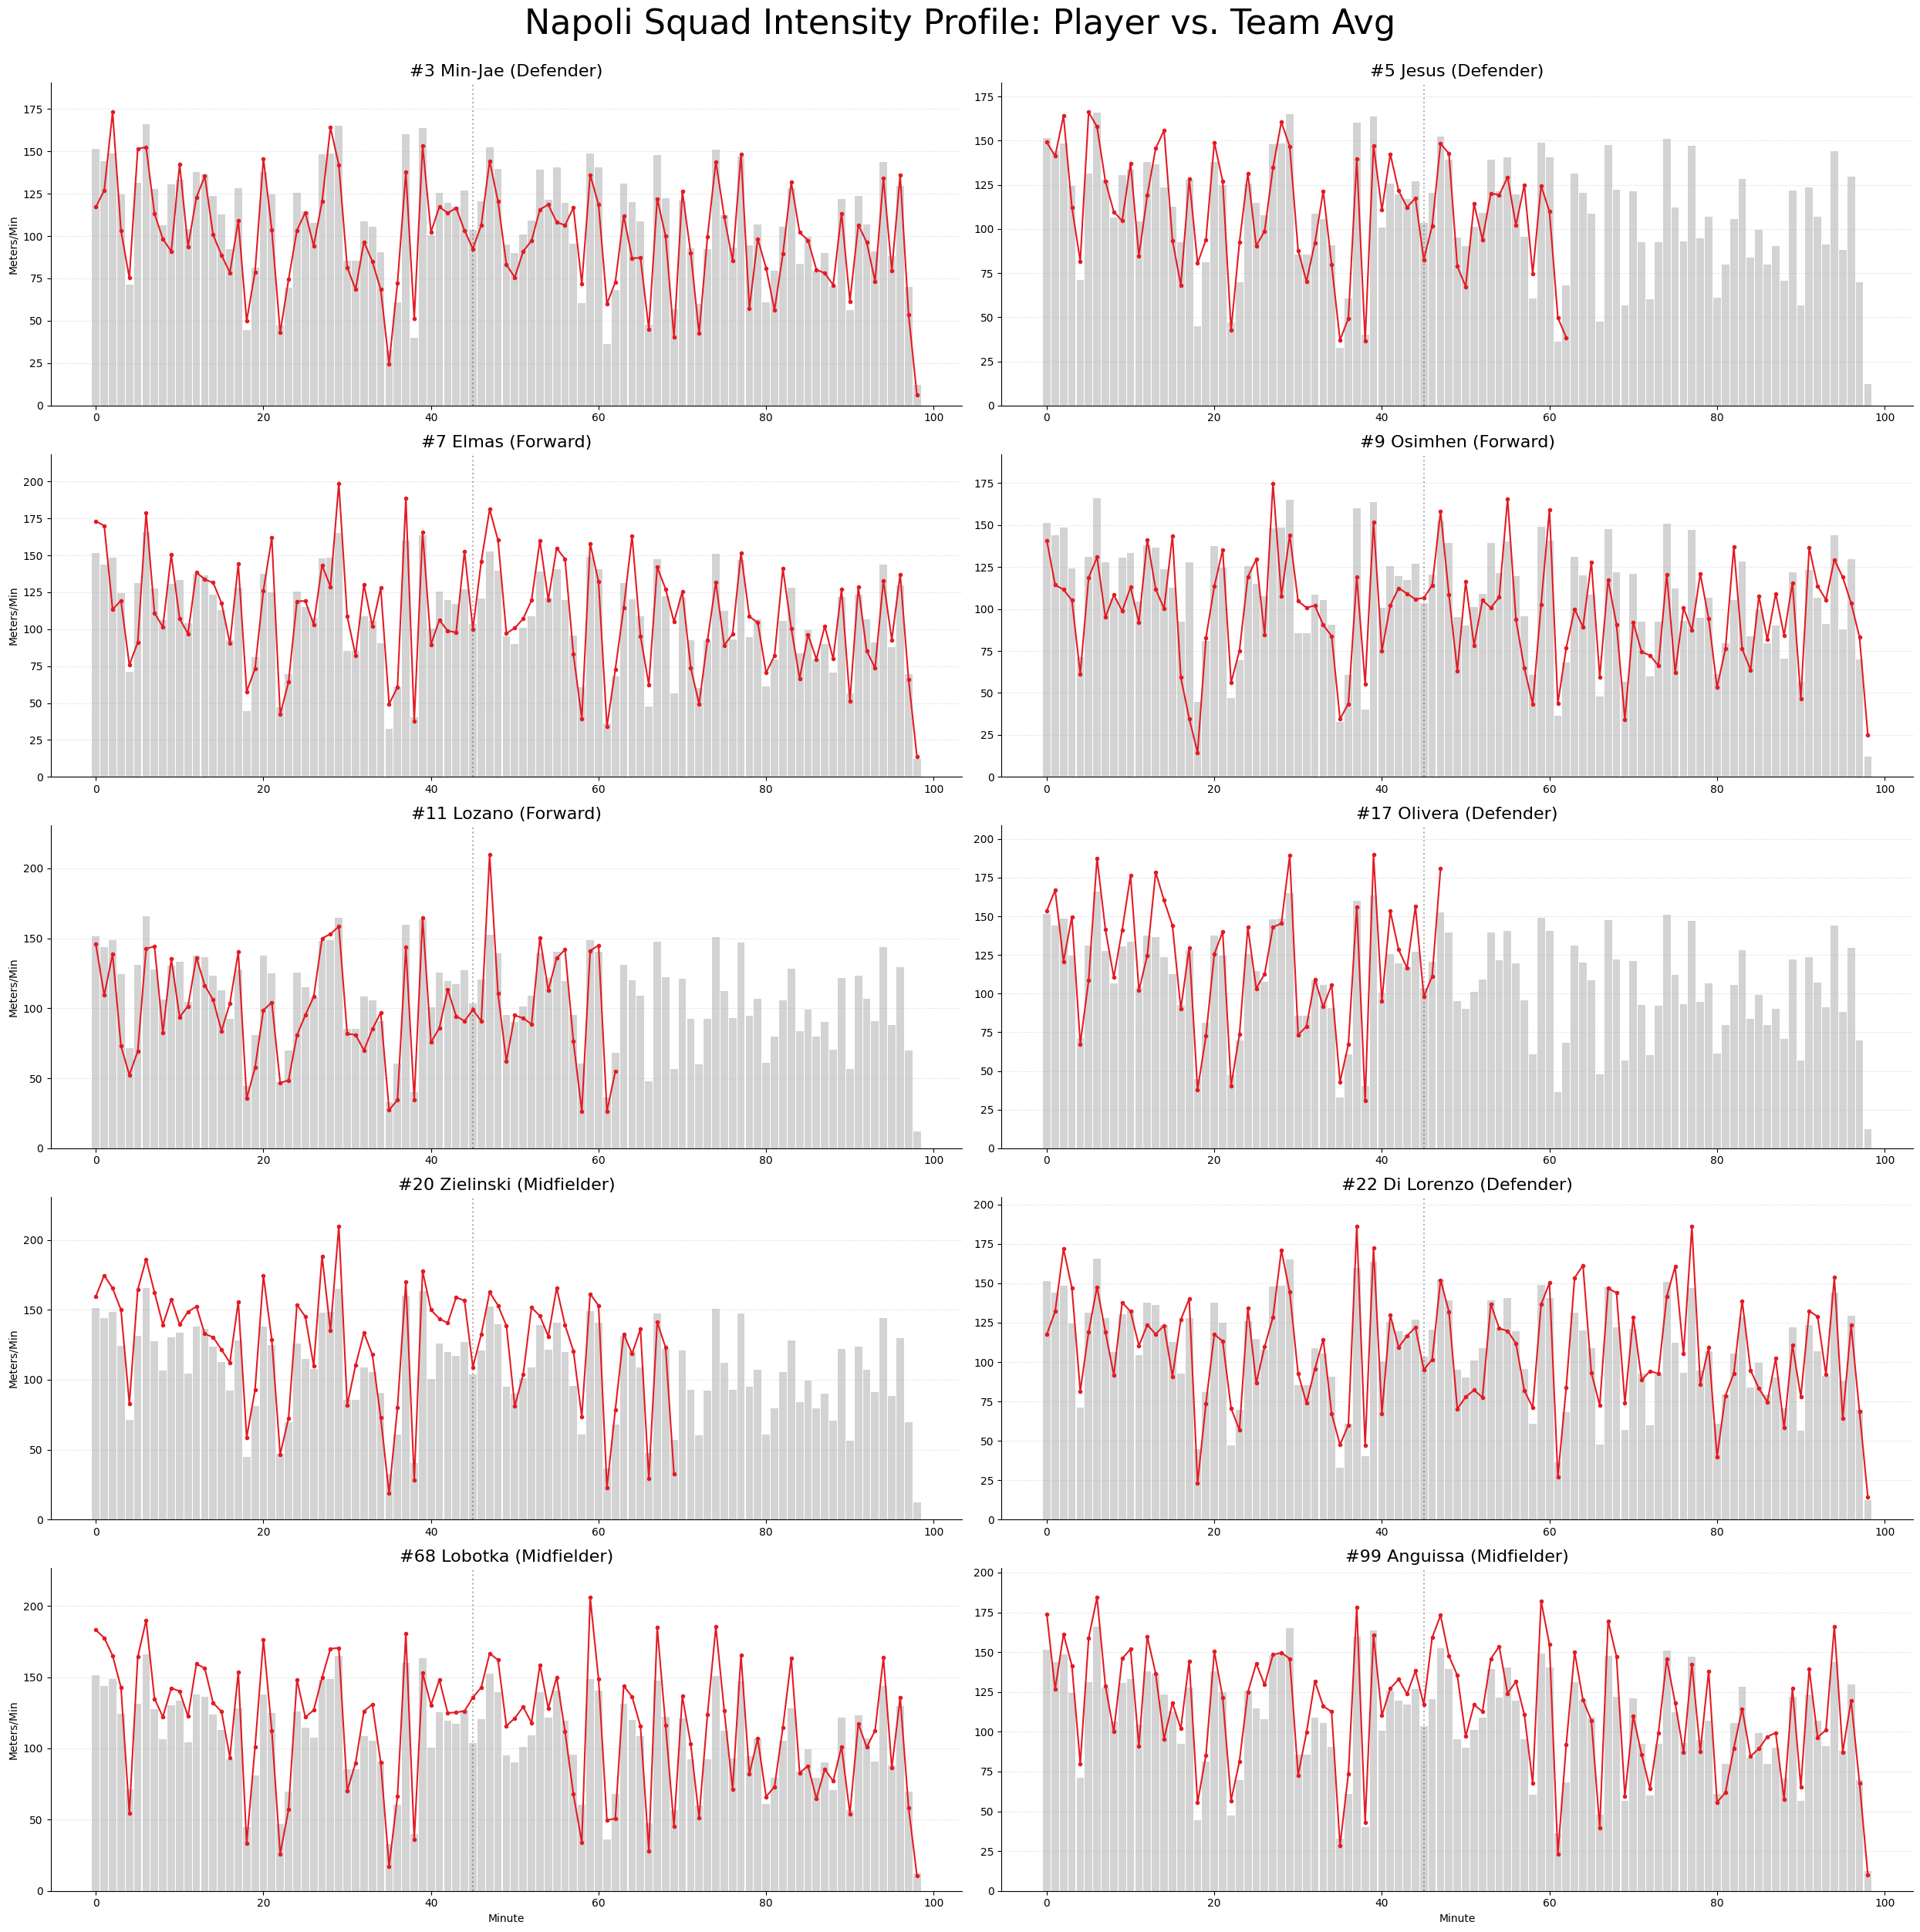

In [45]:
player_workloads, team_avg_dist = calculate_workload_metrics(home_team_dfs)
plot_starting_xi_intensity_v2(starters_data, player_workloads, team_avg_dist)

## Tactical Run Classification

The code implemented below are based on the methodology proposed by Gregory et al. (2019):

**"Ready Player Run: Unsupervised classification of player runs in tracking data"**

Authors: Sam Gregory, Paul Power, Spencer S.H. Robertson.

Link: https://barcainnovationhub.fcbarcelona.com/wp-content/uploads/2020/01/ed15d067-ready-player-run-barcelona-paper-sam-gregory.pdf

Traditional football metrics often focus on "what" happened - passes, shots, and tackles. However, the vast majority of a match is defined by off-the-ball movement. This framework represents a unique way to understand player movement patterns by shifting the focus from absolute GPS coordinates to tactical intent. Instead of viewing a sprint as a simple physical event, we treat it as a deliberate spatial decision made relative to the team's shape.

To implement this methodology, we address two primary questions:

**1. How do we define an "Intentional Run"?**

Not all movement on a football pitch is created equal. A player may be wandering to maintain a defensive block, jogging to recover, or simply adjusting their position.

**2. How do we categorize these runs?**

Once we have extracted thousands of runs from different players and different parts of the pitch, we face a classification challenge. A "diagonal run" in the final third looks very different on a map than a "diagonal run" in the midfield, yet their tactical purpose is the same.

### Part 1: Identification

The first challenge in analyzing player movement is noise. A player is almost always moving, but only a small fraction of that movement is **tactically significant**. To find these moments, we move through a four-step preprocessing pipeline.

**Step 1: Physics Cleaning & Teleportation Detection**

Raw Tracking data often contains "spikes" - moments where a player appears to move at impossible speeds. We calculate raw speed between frames and filter out any "teleportation" (speeds >20 m/s). We then apply a Gaussian Filter to smooth the velocity and acceleration curves, ensuring our triggers aren't tripped by a single jittery data point.

**Step 2: The Intentional Run Detector**

According to the research, a run is defined as a transition between states lasting at least one second:

$$\text{in possession} \xrightarrow{\ge 1s} \text{out of possession}$$

Start Conditions (Must meet both):
- Velocity: $\wedge \quad \|v_i\| \ge 5 \frac{m}{s}$
- Acceleration: $\wedge \quad \|a_i\| \ge 2.5 \frac{m}{s^2}$

End Conditions (Must meet either):
- Velocity: $\vee \quad \|v_i\| \le 4 \frac{m}{s}$
- Deceleration: $\vee \quad \|a_i\| \le -2.5 \frac{m}{s^2}$

This dual-trigger mechanism ensures we capture the exact moment of decision — when a player sees space and commits to an explosive burst of intent.

**Step 3: Tactical & Symmetric Normalization**

Once a run is harvested, it must be normalized so that tactical patterns become visible regardless of where they happen on the pitch. We apply two levels of normalization:
- Centroid Translation: We calculate the Team Centroid (the average position of all outfielders) at the start of the run. We then shift the run's coordinates so they are relative to this tactical center rather than absolute pitch coordinates.
- Lateral Mirroring (Symmetry): To ensure a "right-wing overlap" and a "left-wing overlap" are recognized as the same tactical action, we mirror all trajectories to a single flank. This reduces noise and allows the model to focus on the shape of the run.

**Step 4: Global Harvesting**

Finally, we iterate through the entire squad (excluding goalkeepers) to build a Global Run Library. Every outfielder’s movement is processed through this logic, providing a comprehensive database of every "burst of intent" that occurred during the match. This dataset serves as the input for our secondary challenge: Categorization.

In [46]:
def calculate_acceleration(df, sigma_val=1.5):
    if df is None or df.empty:
        return pd.DataFrame()

    df = df.sort_values('time_key').drop_duplicates(subset=['time_key']).copy()
    
    df['dt'] = df['time_key'].diff()
    valid_dt_mask = (df['dt'] > 0) | (df['dt'].isna())
    df = df[valid_dt_mask].copy()

    # Teleportation Detection
    dx = df['player_x'].diff() * 1.05 
    dy = df['player_y'].diff() * 0.68 
    dist_m = np.sqrt(dx**2 + dy**2)
    
    raw_speed = dist_m / df['dt']
    is_teleport = raw_speed > 20.0
    
    df_clean = df[~is_teleport].copy()

    # Recalculate Physics on Clean Data
    if 'player_speed' in df_clean.columns:
        base_velocity = df_clean['player_speed'].fillna(0)
    else:
        dx_clean = df_clean['player_x'].diff().fillna(0) * 1.05
        dy_clean = df_clean['player_y'].diff().fillna(0) * 0.68
        dist_clean = np.sqrt(dx_clean**2 + dy_clean**2)
        base_velocity = dist_clean / df_clean['dt']

    # Apply Smoothing
    df_clean['velocity'] = gaussian_filter1d(base_velocity.fillna(0), sigma=sigma_val)
    df_clean['dt_clean'] = df_clean['time_key'].diff()
    raw_accel = df_clean['velocity'].diff() / df_clean['dt_clean']
    df_clean['acceleration'] = gaussian_filter1d(raw_accel.fillna(0), sigma=sigma_val)
    
    return df_clean.fillna(0)

In [47]:
def get_intentional_runs_raw(df):
    runs = []
    is_running = False
    current_run = []
    
    for i, row in df.iterrows():
        # START TRIGGER: Fast and Accelerating
        if not is_running:
            if row['velocity'] >= 5.0 and row['acceleration'] >= 2.5:
                is_running = True
                current_run.append(row)
        
        # DURING THE RUN
        else:
            current_run.append(row)
            
            # END TRIGGER: Dropped below 4 m/s OR Braking hard
            if row['velocity'] <= 4.0 or row['acceleration'] <= -2.5:
                # Must be at least 1 second (50 frames at 50 FPS)
                if len(current_run) >= 50:
                    runs.append(pd.DataFrame(current_run))
                
                # Reset
                current_run = []
                is_running = False
                
    return runs

In [48]:
def get_all_team_runs(home_team_dfs):
    all_runs_global = []
    
    for p_id, p_df in home_team_dfs.items():
        if p_df['player_role'].iloc[0] == 'Goalkeeper':
            continue
            
        p_df_cleaned = calculate_acceleration(p_df, sigma_val=2.0)
        
        p_runs = get_intentional_runs_raw(p_df_cleaned)

        for run in p_runs:
            run['origin_player_id'] = p_id
            all_runs_global.append(run)
            
    print(f"Cumulative Harvest: {len(all_runs_global)} runs from all outfielders.")
    return all_runs_global

In [49]:
def get_runs_with_context(player_runs, home_team_dfs):
    runs_context = []
    
    for i, run_df in enumerate(player_runs):
        # Get the start time of this specific run
        start_time = run_df['time_key'].iloc[0]
        
        # Find all teammates on the pitch at this exact frame
        teammates_at_start = []
        for p_id, p_df in home_team_dfs.items():
            frame_data = p_df[p_df['time_key'] == start_time]
            
            if not frame_data.empty:
                player_row = frame_data.iloc[0]
                teammates_at_start.append({
                    'player_id': p_id,
                    'x': player_row['player_x'],
                    'y': player_row['player_y'],
                    'role': player_row.get('player_role', 'Outfield')
                })
        
        # Calculate Centroid 
        outfield = [p for p in teammates_at_start if p['role'] != 'Goalkeeper']
        target_group = outfield if outfield else teammates_at_start
        
        c_x = np.mean([p['x'] for p in target_group])
        c_y = np.mean([p['y'] for p in target_group])
        
        # 4. Store metadata for this run
        runs_context.append({
            'run_index': i,
            'start_time': start_time,
            'centroid_start': (c_x, c_y),
            'teammates': target_group,
            'trajectory': run_df.copy() 
        })
        
    return runs_context

In [50]:
def get_mirrored_context(runs_metadata):
    mirrored_metadata = []
    
    for meta in runs_metadata:
        # Check Flip Condition (Wyscout Y > 50 is Bottom/Right Wing)
        # We want everything on Top/Left (Y < 50)
        start_y = meta['trajectory']['player_y'].iloc[0]
        should_flip = start_y > 50
        
        # Flip Trajectory
        traj_mirrored = meta['trajectory'].copy()
        if should_flip:
            traj_mirrored['player_y'] = 100 - traj_mirrored['player_y']
            
        # Flip Teammates (For visualization only)
        teammates_mirrored = []
        for p in meta['teammates']:
            new_y = 100 - p['y'] if should_flip else p['y']
            teammates_mirrored.append({
                'player_id': p['player_id'],
                'role': p['role'],
                'x': p['x'],
                'y': new_y
            })
            
        # Flip Centroid (Direct Math)
        cx, cy = meta['centroid_start']
        if should_flip:
            cy = 100 - cy
            
        # Store
        mirrored_metadata.append({
            'run_index': meta['run_index'],
            'start_time': meta['start_time'],
            'is_flipped': should_flip,
            'centroid_start': (cx, cy),   
            'teammates': teammates_mirrored,
            'trajectory': traj_mirrored
        })
        
    return mirrored_metadata

In [51]:
def normalize_to_pitch_center(mirrored_metadata):
    normalized_runs = []
    pitch_center_x, pitch_center_y = 50, 50

    for meta in mirrored_metadata:
        c_start_x, c_start_y = meta['centroid_start']
        traj = meta['trajectory'].copy()
        
        shift_x = pitch_center_x - c_start_x
        shift_y = pitch_center_y - c_start_y
        
        traj['norm_x'] = traj['player_x'] + shift_x
        traj['norm_y'] = traj['player_y'] + shift_y
        
        norm_teammates = []
        for p in meta['teammates']:
            norm_teammates.append({
                'player_id': p['player_id'],
                'role': p['role'],
                'x': p['x'] + shift_x,
                'y': p['y'] + shift_y
            })
            
        normalized_runs.append({
            'run_index': meta['run_index'],
            'shift_vector': (shift_x, shift_y),
            'norm_centroid': (50, 50), 
            'norm_teammates': norm_teammates,
            'norm_trajectory': traj
        })
        
    return normalized_runs

In [52]:
global_player_runs = get_all_team_runs(home_team_dfs)

runs_metadata = get_runs_with_context(global_player_runs, home_team_dfs)

mirrored_metadata = get_mirrored_context(runs_metadata)

final_normalized_runs = normalize_to_pitch_center(mirrored_metadata)

Cumulative Harvest: 580 runs from all outfielders.


In [53]:
def visualize_processing_stages(runs_meta, mirrored_meta, norm_meta, run_index):
    fig, axes = plt.subplots(1, 3, figsize=(24, 12), facecolor='white')
    
    pitch = VerticalPitch(
        pitch_type='wyscout',
        pitch_color='white',
        line_color='black',
        pad_bottom=5, pad_top=5, pad_left=5, pad_right=5
    )
    
    raw_data = runs_meta[run_index]
    mirr_data = mirrored_meta[run_index]
    norm_data = norm_meta[run_index]
    
    stages = [
        {
            'ax': axes[0],
            'title': f"1. Raw Data",
            'teammates': raw_data['teammates'],
            'centroid': raw_data['centroid_start'],
            'traj': raw_data['trajectory'],
            'x_col': 'player_x', 'y_col': 'player_y'
        },
        {
            'ax': axes[1],
            'title': f"2. Mirrored to Left Wing",
            'teammates': mirr_data['teammates'],
            'centroid': mirr_data['centroid_start'],
            'traj': mirr_data['trajectory'],
            'x_col': 'player_x', 'y_col': 'player_y'
        },
        {
            'ax': axes[2],
            'title': "3. Normalized (Shifted)",
            'teammates': norm_data['norm_teammates'],
            'centroid': norm_data['norm_centroid'],
            'traj': norm_data['norm_trajectory'],
            'x_col': 'norm_x', 'y_col': 'norm_y'
        }
    ]
    
    for i, stage in enumerate(stages):
        ax = stage['ax']
        pitch.draw(ax=ax)
        
        outfielders = [p for p in stage['teammates'] if p.get('role') != 'Goalkeeper']
        tm_x = [p['x'] for p in outfielders]
        tm_y = [p['y'] for p in outfielders]
        
        pitch.scatter(tm_x, tm_y, s=150, color='cyan', edgecolors='black', 
                      label='Teammates', ax=ax, zorder=3)
        
        cx, cy = stage['centroid']
        pitch.scatter(cx, cy, s=250, color='red', marker='H', edgecolors='black', 
                      label='Team Centroid', ax=ax, zorder=4)
        
        traj = stage['traj']
        pitch.plot(traj[stage['x_col']], traj[stage['y_col']], 
                   color='orange', linewidth=4, label='Run Path', ax=ax, zorder=5)
        
        run_start_x = traj[stage['x_col']].iloc[0]
        run_start_y = traj[stage['y_col']].iloc[0]
        pitch.scatter(run_start_x, run_start_y, 
                      color='orange', s=150, edgecolors='black', ax=ax, zorder=6)
        
        if i == 2: 
            old_cx, old_cy = mirr_data['centroid_start']
            old_rx = mirr_data['trajectory']['player_x'].iloc[0]
            old_ry = mirr_data['trajectory']['player_y'].iloc[0]
            
            new_cx, new_cy = norm_data['norm_centroid']
            new_rx = run_start_x
            new_ry = run_start_y
            
            pitch.lines(old_cx, old_cy, new_cx, new_cy, ax=ax,
                        color='red', lw=2, linestyle='--', alpha=0.5, 
                        label='Centroid Shift')
  
            pitch.lines(old_rx, old_ry, new_rx, new_ry, ax=ax,
                        color='orange', lw=2, linestyle='--', alpha=0.5,
                        label='Run Shift')

        ax.set_title(stage['title'], color='black', fontsize=18, pad=15)

    axes[2].legend(loc='lower right', fontsize=10, facecolor='white', framealpha=1)
    plt.tight_layout()
    plt.show()

Here is a visualization showing how each run is being processed step by step.

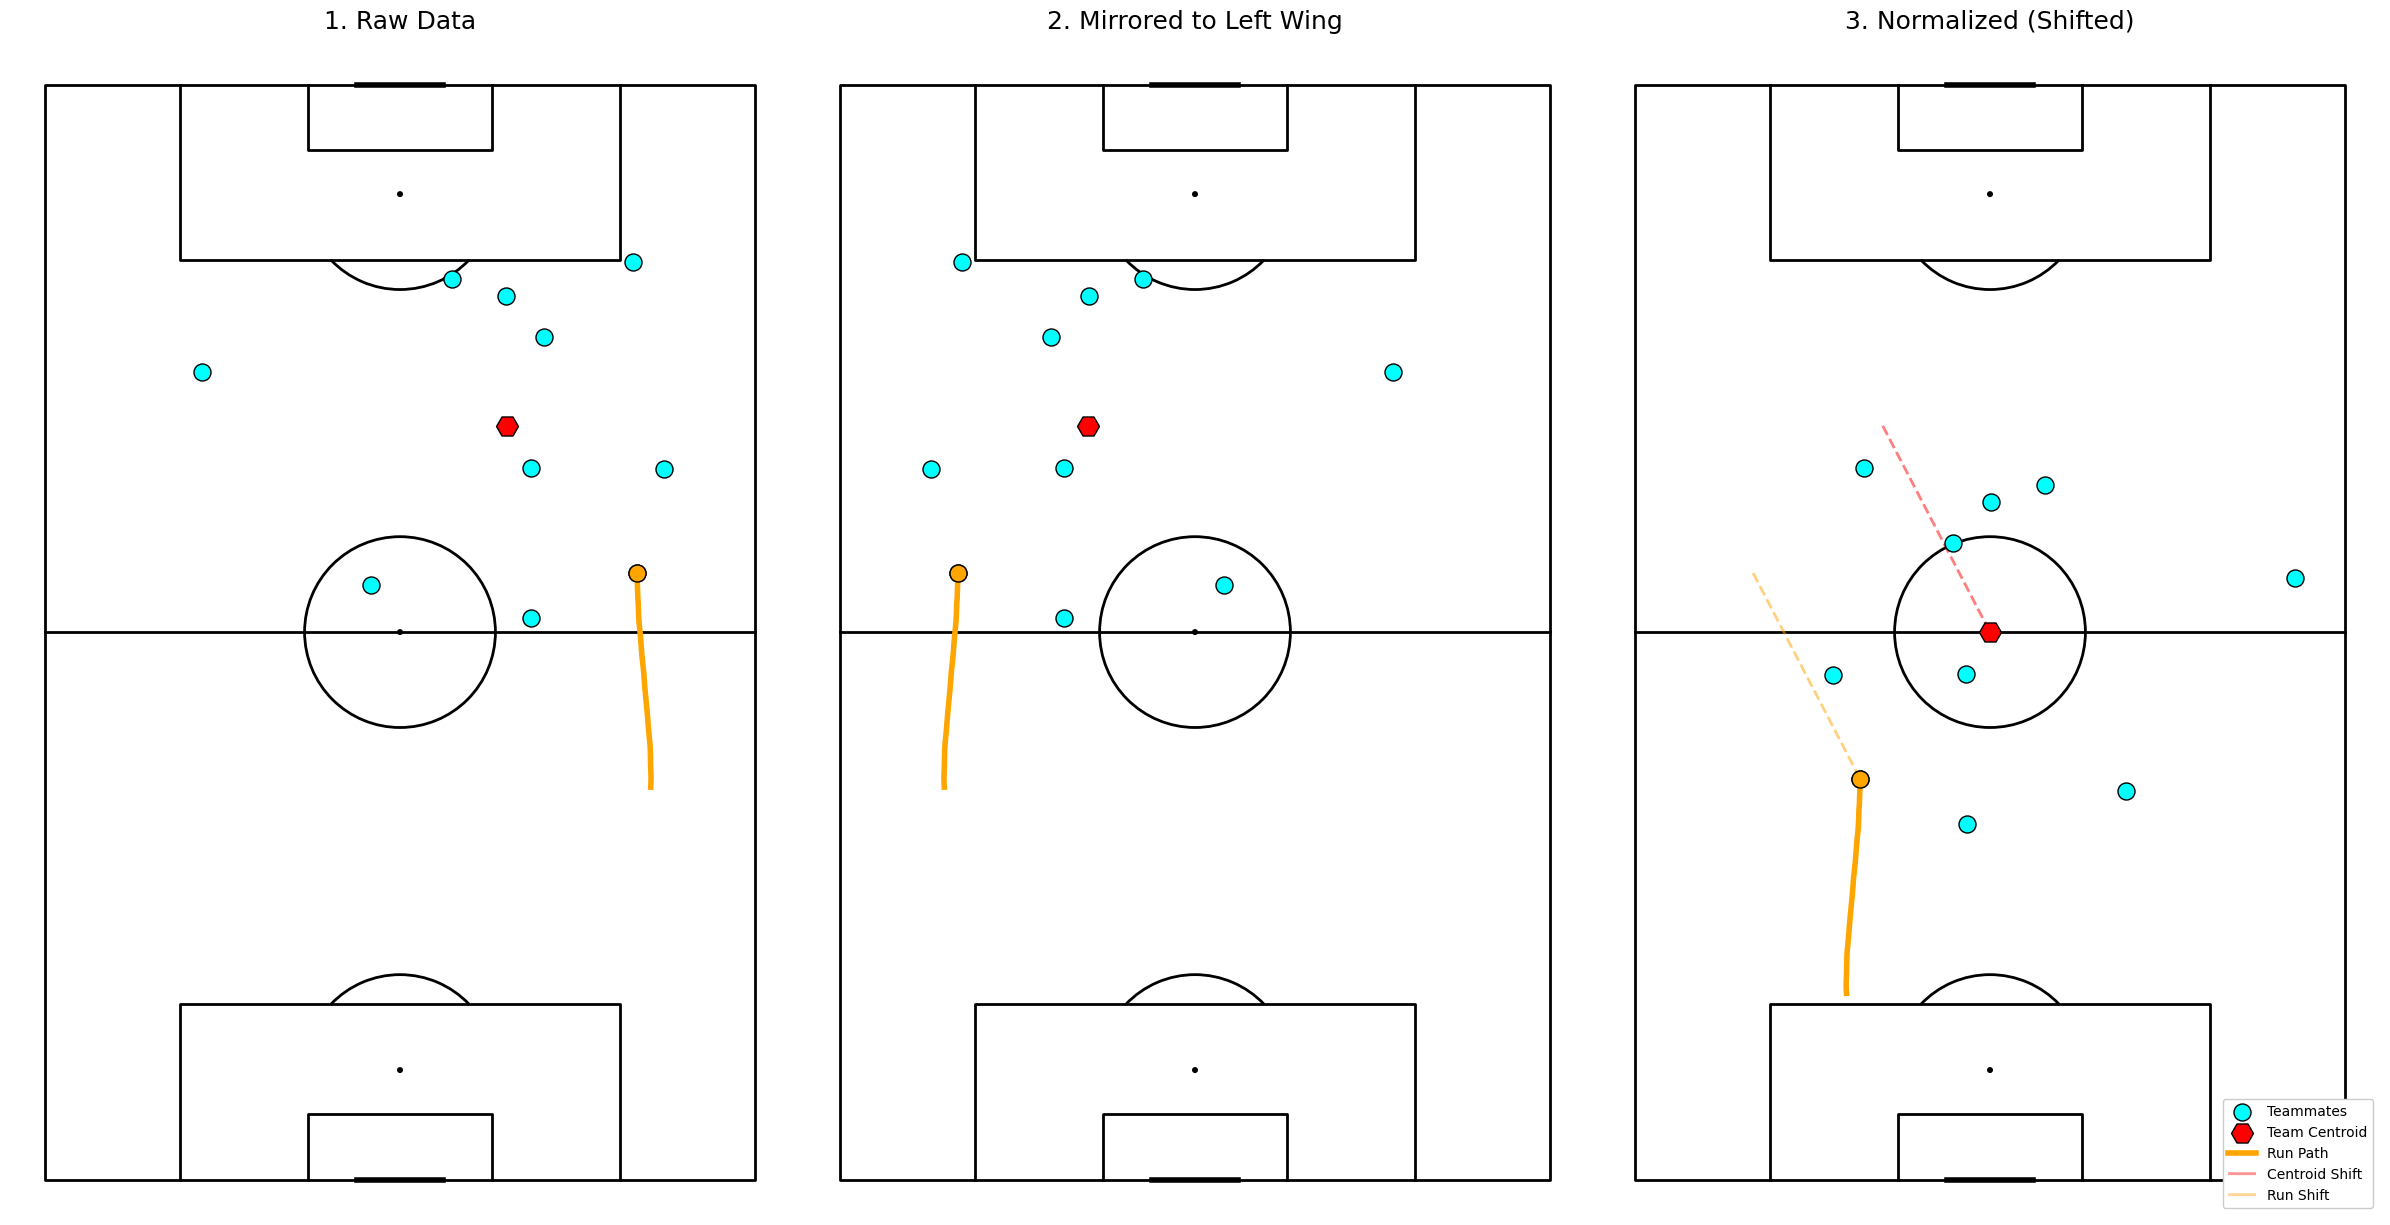

In [54]:
visualize_processing_stages(runs_metadata, mirrored_metadata, final_normalized_runs, 3)

### Part 2: Classification

Once we have successfully extracted "Intentional Runs" from the noise of the match, we face a secondary challenge: categorization. Because every run has a different length and occurs on a different part of the pitch, standard Euclidean comparisons fail. To solve this, we utilize **Bézier-based K-Means Clustering**.

This process transforms thousands of unique, squiggly trajectories into a small set of "Common Run" archetypes.

**Step 1. Mathematical Compression: Bernstein Polynomials**

We use Cubic Bézier Curves (P=4) to model each run. `get_bernstein_matrix()` generates a matrix of Bernstein polynomials that acts as the "basis" for our curve. Instead of tracking 100 individual (x,y) frames, we only need to track 4 control points (θ) that define the run's fundamental shape.

**Step 2. Finding the "Best Fit" for a Group**

`fit_cluster_bezier()` solves a Least Squares problem. It stacks the matrices and coordinates of multiple runs simultaneously to calculate a single set of control points (θ) that minimizes the overall error. This resulting curve becomes the "Centroid" or "Archetype" for that specific cluster.

**Step 3. Measuring Similarity: L1 Distance**

Rather than measuring point-to-point, we measure the Average Absolute Difference (L1) between the raw trajectory and the theoretical Bézier curve using `calculate_l1_dist()`. A lower L1 score indicates that the run matches the "flavor" of that specific movement archetype.

**Step 4. The Iterative Optimization: Bézier K-Means**

This is the "brain" of the categorization process, where the categories are actually discovered.

Each run is compared to every cluster center (k=12) and assigned to the one with the lowest L1 distance. Once assignments are made, the function recalculates the cluster centers by re-fitting a Bézier curve to all runs currently in that group. This loop repeats until the "Objective Function" (the average error) stops decreasing, signaling that the archetypes are stable.

In [55]:
def get_bernstein_matrix(n_frames, P=4):
    t = np.linspace(0, 1, n_frames)
    degree = P - 1
    M = np.zeros((n_frames, P))
    for p in range(P):
        M[:, p] = comb(degree, p) * (t**p) * ((1 - t)**(degree - p))
    return M

def calculate_l1_dist(trajectory, cluster_theta):
    d_r = len(trajectory)
    M_r = get_bernstein_matrix(d_r, P=len(cluster_theta))
    curve_points = M_r @ cluster_theta
    # Average absolute difference across both dimensions
    return np.sum(np.abs(trajectory - curve_points)) / d_r

def fit_cluster_bezier(trajectories, P=4):
    all_M, all_X = [], []
    for traj in trajectories:
        all_M.append(get_bernstein_matrix(len(traj), P=P))
        all_X.append(traj)
    
    M_total = np.vstack(all_M)
    X_total = np.vstack(all_X)
    theta, _, _, _ = np.linalg.lstsq(M_total, X_total, rcond=None)
    return theta

In [56]:
def bezier_kmeans_scrupulous(run_trajectories, k=12, max_iter=20, P=4):
    """Main Iterative Loop: Assignment -> Update -> Convergence."""
    indices = np.random.choice(len(run_trajectories), k, replace=False)
    cluster_centers = [fit_cluster_bezier([run_trajectories[idx]], P=P) for idx in indices]
    
    prev_objective = float('inf')
    
    for m in range(max_iter):
        assignments = []
        distances = []
        for run in run_trajectories:
            dists = [calculate_l1_dist(run, theta) for theta in cluster_centers]
            best_cluster = np.argmin(dists)
            assignments.append(best_cluster)
            distances.append(dists[best_cluster])

        current_objective = np.mean(distances)
        print(f"Iteration {m}: Avg L1 Distance = {current_objective:.4f}")

        if abs(prev_objective - current_objective) < 1e-5:
            print("Converged.")
            break
        prev_objective = current_objective
        
        new_centers = []
        for j in range(k):
            assigned_runs = [run_trajectories[i] for i, a in enumerate(assignments) if a == j]
            if assigned_runs:
                new_centers.append(fit_cluster_bezier(assigned_runs, P=P))
            else:
                rand_idx = np.random.randint(len(run_trajectories))
                new_centers.append(fit_cluster_bezier([run_trajectories[rand_idx]], P=P))
        cluster_centers = new_centers
        
    return assignments, cluster_centers

In [57]:
X_trajectories = [
    run['norm_trajectory'][['norm_x', 'norm_y']].values 
    for run in final_normalized_runs
]

print(f"Dataset ready: {len(X_trajectories)} trajectories for Bézier clustering.")

Dataset ready: 580 trajectories for Bézier clustering.


In [58]:
assignments, cluster_curves = bezier_kmeans_scrupulous(
    X_trajectories, 
    k=12, 
    P=4 
)

for i, meta in enumerate(final_normalized_runs):
    meta['cluster_id'] = assignments[i]

Iteration 0: Avg L1 Distance = 10.7202
Iteration 1: Avg L1 Distance = 9.6540
Iteration 2: Avg L1 Distance = 9.2423
Iteration 3: Avg L1 Distance = 8.9015
Iteration 4: Avg L1 Distance = 8.7963
Iteration 5: Avg L1 Distance = 8.7871
Iteration 6: Avg L1 Distance = 8.7364
Iteration 7: Avg L1 Distance = 8.7046
Iteration 8: Avg L1 Distance = 8.7041
Iteration 9: Avg L1 Distance = 8.6966
Iteration 10: Avg L1 Distance = 8.6858
Iteration 11: Avg L1 Distance = 8.6872
Iteration 12: Avg L1 Distance = 8.6872
Converged.


In [59]:
def evaluate_bezier(theta, n_points=50):
    M = get_bernstein_matrix(n_points, P=len(theta))
    return M @ theta

In [60]:
def visualize_bezier_clusters(metadata, cluster_curves, k=12):
    ncols = 4
    nrows = (k + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(24, 8 * nrows), facecolor='white')
    axes = axes.flatten()
    
    pitch = VerticalPitch(
        pitch_type='wyscout', 
        pitch_color='white', 
        line_color='black'
    )

    for i in range(k):
        ax = axes[i]
        pitch.draw(ax=ax)
        
        cluster_runs = [m for m in metadata if m['cluster_id'] == i]
        
        for run_meta in cluster_runs:
            traj = run_meta['norm_trajectory']
            pitch.plot(traj['norm_x'], traj['norm_y'], ax=ax, 
                       color='black', alpha=0.25, linewidth=1, zorder=2)
            
        archetype_coords = evaluate_bezier(cluster_curves[i])
        
        pitch.plot(archetype_coords[:, 0], archetype_coords[:, 1], ax=ax, 
                   color='black', linewidth=4, zorder=5)
        
        pitch.scatter(archetype_coords[0, 0], archetype_coords[0, 1], 
                      color='cyan', s=100, ax=ax, zorder=6)

        ax.set_title(f"Cluster {i} (n={len(cluster_runs)})", fontsize=16, pad=10)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Squad Movement Archetypes (K={k})\nBézier Clustering | Standardized to Team Centroid", 
                 fontsize=26, y=1.)
    plt.tight_layout()
    plt.show()

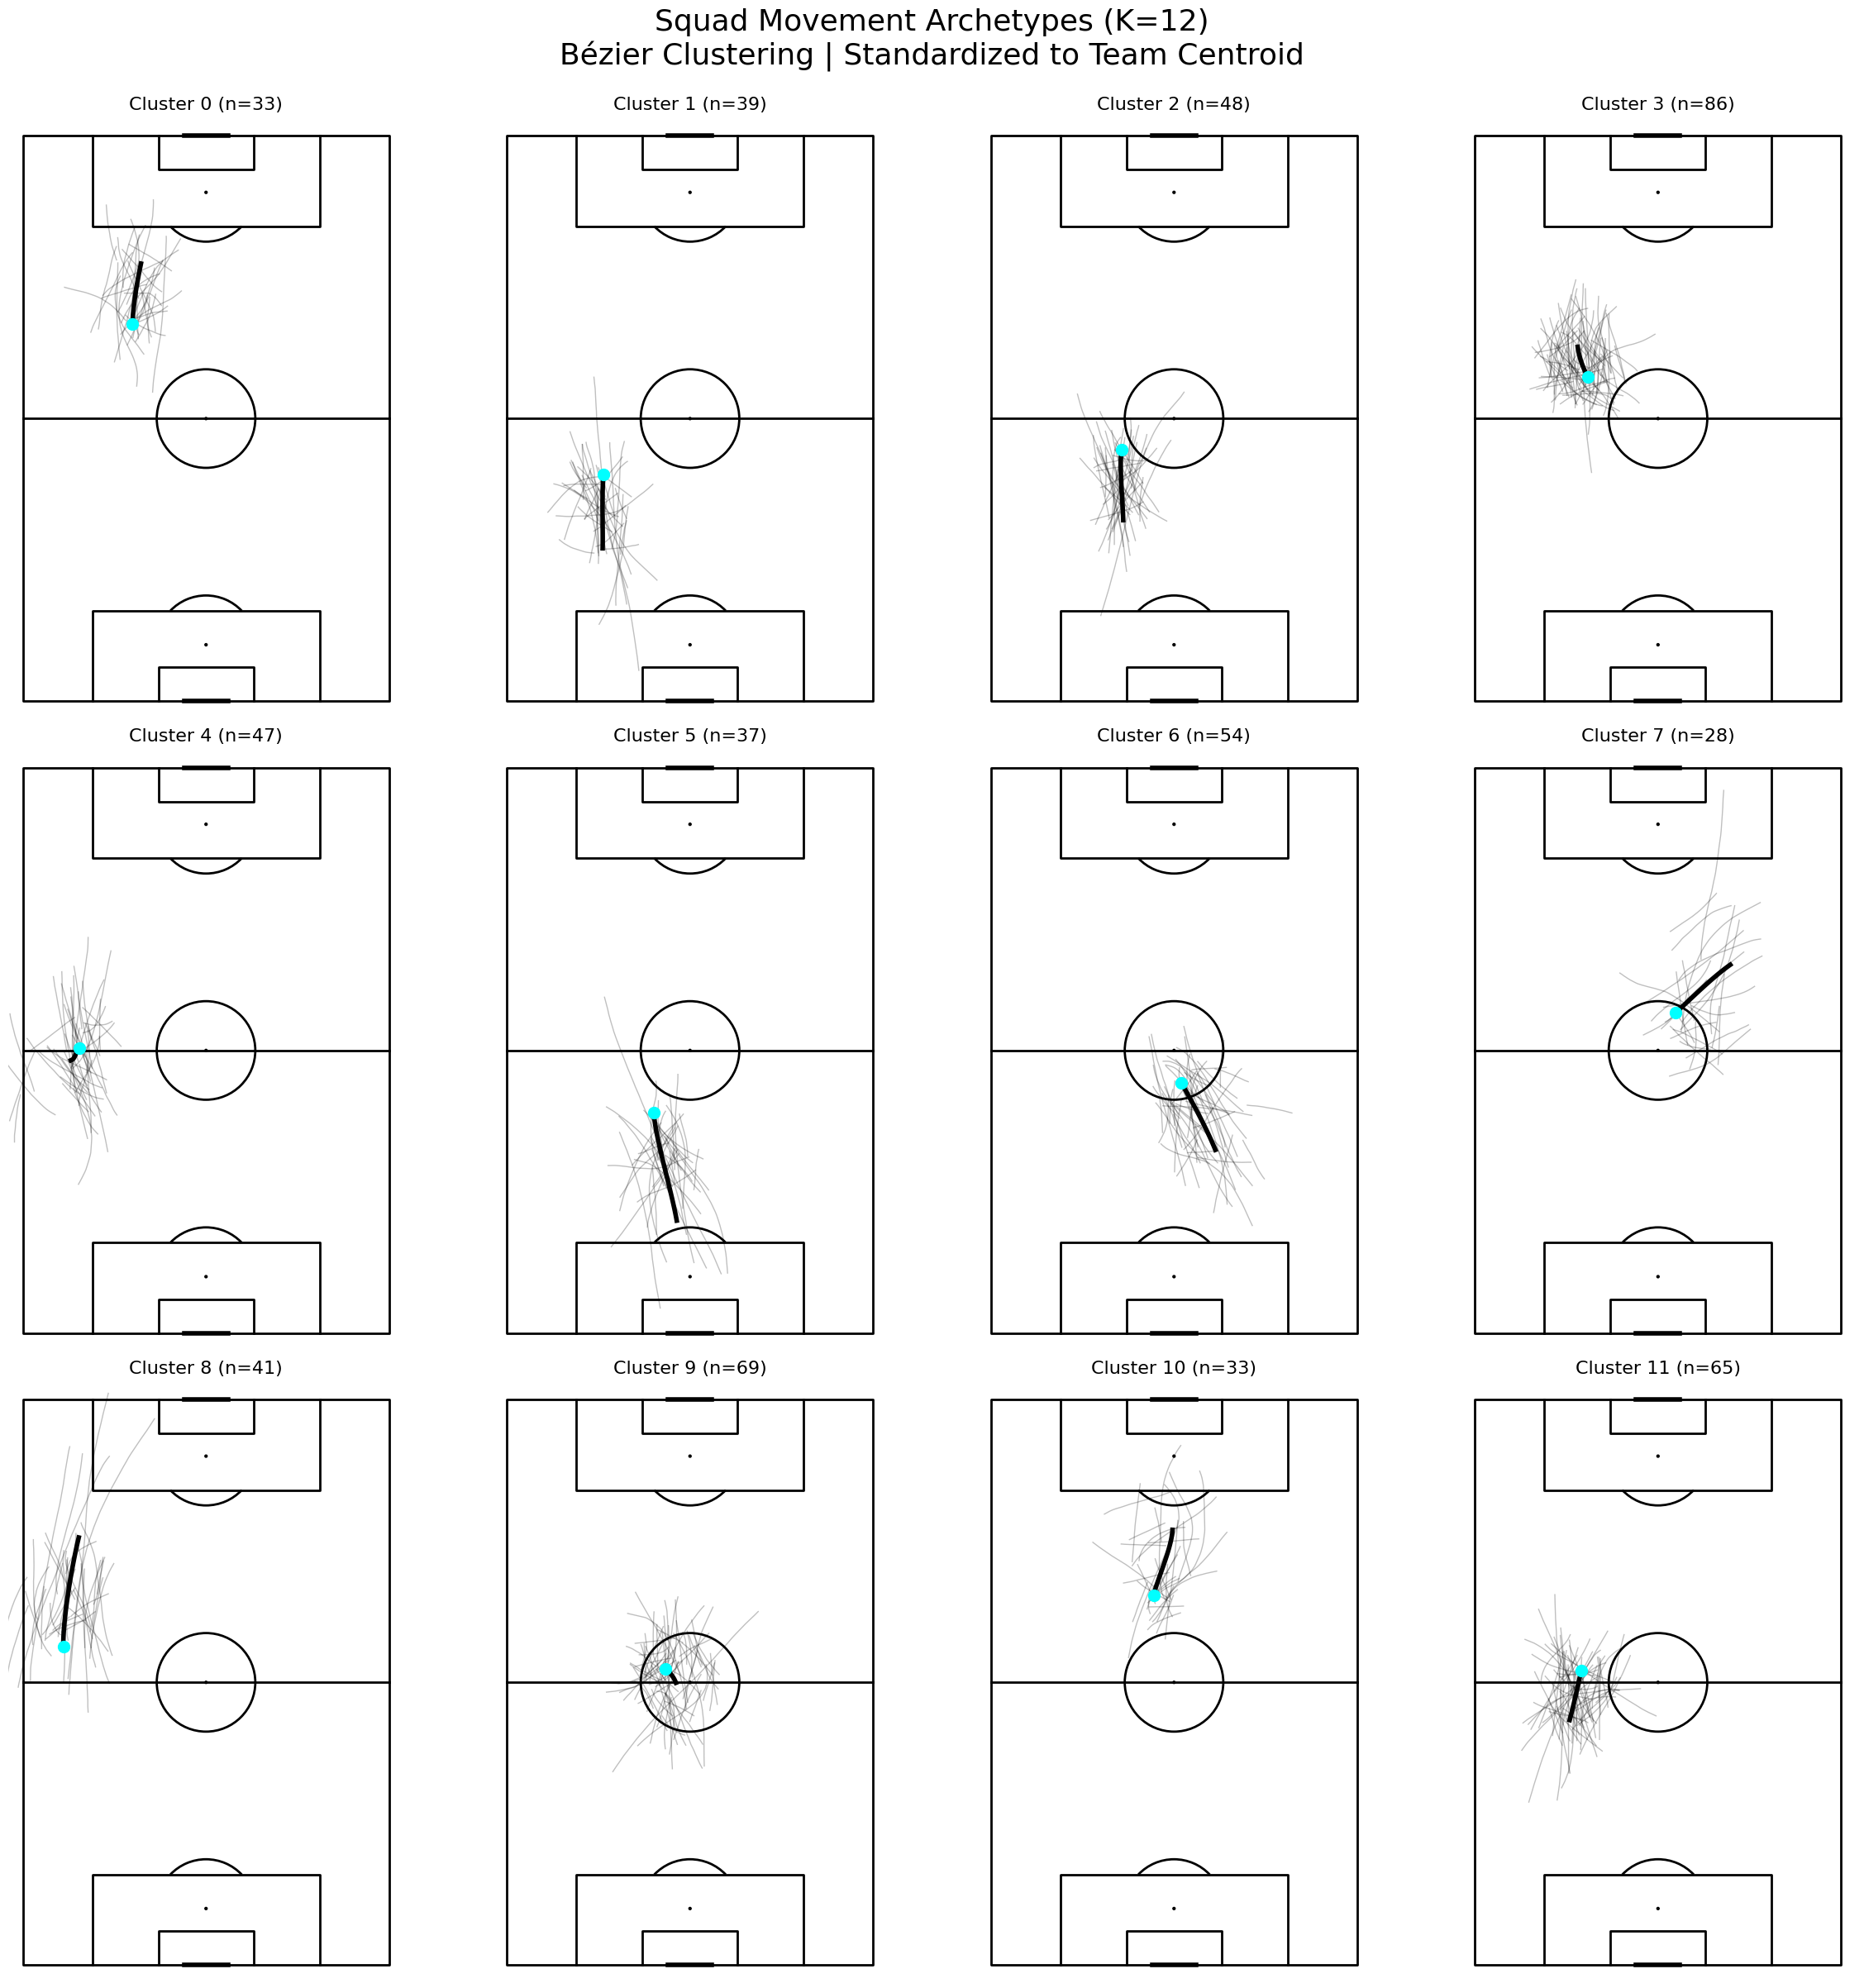

In [61]:
visualize_bezier_clusters(final_normalized_runs, cluster_curves, k=12)

While this implementation examines the entire team’s movement due to the scope of our current dataset, the true potential of this framework lies in long-term scouting and individual profiling; by applying these Bézier-clustering techniques to a single player's tracking data over multiple matches or entire seasons, analysts can identify their "signature" movement patterns and uncover the unique tactical fingerprint that defines their game.